In [ ]:
import os
import warnings
os.chdir('..')
warnings.filterwarnings('ignore')

# Firstly import the class of dataset
from Scripts.Data_Loader import EIRDataset

In [1]:
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from Scripts.EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
#from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
from pathlib import Path

# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

##################### Process, filter and epoch the data ######################
data_path = sample.data_path()

# Set parameters and read data
#raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
#event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
raw_fname = data_path / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"
event_fname = data_path / "MEG" / "sample" / "sample_audvis_filt-0-40_raw-eve.fif"
tmin, tmax = -0., 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir')  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
labels = epochs.events[:, -1]

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels

ModuleNotFoundError: No module named 'Scripts'

In [ ]:
epochs.get_data().shape

In [ ]:
epochs.get_data()*1000

In [ ]:
type(X)

In [ ]:
len(X[0])

In [2]:
import os
import warnings
os.chdir('..')
warnings.filterwarnings('ignore')

# Firstly import the class of dataset
from Scripts.Data_Loader import EIRDataset

EIR_Dataset = EIRDataset('/repo/EEG-Image-Reconstruction/Generated/Data_Train/', task_type='geometric', n_jobs=10) # task type can be `geometric` or `random` or `all`

Processing exp_paths:   0%|          | 0/31 [00:00<?, ?it/s]

Loading .fif files: 100%|██████████| 434/434 [00:08<00:00, 52.89it/s]


In [2]:
for i in range(len(EIR_Dataset)): 
    eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]
    eeg_sample.resample(128)


In [2]:
for i in range(len(EIR_Dataset)): 
    eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]
    eeg_sample.resample(256)

In [ ]:
eeg_sample

In [ ]:
metadata

In [3]:
import numpy as np
def get_sample(subj_id = None, get_pixel = False):
    meta = []
    y = []
    X = []
    labels = []
    for i in range(len(EIR_Dataset)): 
        eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]
        if subj_id == None:
            meta.append(metadata)
            y.append(img.flatten())
            labels.append(label)
            X.append(eeg_sample.get_data())
        if isinstance(subj_id, list):
            if metadata['subject_id'] in subj_id:
                meta.append(metadata)
                y.append(img.flatten())
                labels.append(label)
                X.append(eeg_sample.get_data())
        if isinstance(subj_id, int):
            if metadata['subject_id'] == subj_id:
                meta.append(metadata)
                y.append(img.flatten())
                labels.append(label)
                X.append(eeg_sample.get_data())
    if get_pixel:
        y = [t[get_pixel[0]*6 + get_pixel[1]] for t in y]
    X = np.stack(X)
    y = np.array(y)
    labels = np.array(labels)
    return X, y, labels

def get_sample_choosen_trial(subj_id = None, choosen_trial = None):
    meta = []
    y = []
    X = []
    labels = []
    for i in range(len(EIR_Dataset)): 
        eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]
        if subj_id == None and metadata['trial_id'] in choosen_trial:
            meta.append(metadata)
            y.append(img.flatten())
            labels.append(label)
            X.append(eeg_sample.get_data())
        if isinstance(subj_id, list):
            if metadata['subject_id'] in subj_id and metadata['trial_id'] in choosen_trial:
                meta.append(metadata)
                y.append(img.flatten())
                labels.append(label)
                X.append(eeg_sample.get_data())
        if isinstance(subj_id, int):
            if metadata['subject_id'] == subj_id and metadata['trial_id'] in choosen_trial:
                meta.append(metadata)
                y.append(img.flatten())
                labels.append(label)
                X.append(eeg_sample.get_data())
    X = np.stack(X)
    y = np.array(y)
    labels = np.array(labels)
    return X, y, labels

def get_sample_exclude(subj_id: int):
    meta = []
    y = []
    X = []
    labels = []
    for i in range(len(EIR_Dataset)): 
        eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]
        if metadata['subject_id'] != subj_id:
            meta.append(metadata)
            y.append(img.flatten())
            labels.append(label)
            X.append(eeg_sample.get_data())
    X = np.stack(X)
    y = np.array(y)
    labels = np.array(labels)
    return X, y, labels

def get_target_pairs():
    targs = {}
    for i in range(len(EIR_Dataset)):
        eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]
        if label in targs.keys():
            if not np.array_equal(targs[label], img): print('ахтунг')
        else:
            targs[label] = img
    return targs

In [4]:
y = get_sample(get_pixel = [2, 2])[1]
y

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,

In [6]:
from collections import Counter
Counter(get_sample()[2])

Counter({11: 41,
         6: 40,
         10: 39,
         4: 39,
         3: 38,
         5: 34,
         2: 31,
         8: 31,
         7: 31,
         1: 30,
         0: 28,
         9: 28,
         12: 24})

In [ ]:
get_target_pairs()

In [ ]:
meta = []
y = []
X = []
labels = []
for i in range(len(EIR_Dataset)):
        eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]
        metadata['label'] = label
        meta.append(metadata)
        y.append(img.flatten())
        labels.append(label)
        X.append(eeg_sample.get_data())


In [ ]:
import pandas as pd
df = pd.DataFrame(meta)
df

In [ ]:
label_trial_counts = (
    df.groupby(['subject_id', 'label'])['trial_id']
    .nunique()  # Count unique trials per (subject, label)
    .reset_index(name='unique_trial_count')
)

# Filter cases where the same label appears in ≥2 different trials
repeated_labels = label_trial_counts[label_trial_counts['unique_trial_count'] > 1]

# Get the original rows matching these cases
result = df.merge(
    repeated_labels[['subject_id', 'label']],
    on=['subject_id', 'label'],
    how='inner'
).sort_values(['subject_id', 'trial_id', 'label'])

result[['subject_id', 'label']].drop_duplicates()

In [ ]:
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from Scripts.EEGModels import EEGNet_Regression, EEGNet_Regression_One_Exit
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
#from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
# Assuming X and y are already loaded
# y should now be a 2D array with shape (n_samples, 36) for regression

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
kernels, chans, samples = 1, 63, 2048

def compute_ssim(matrix1, matrix2):
    X = np.array(matrix1).astype(float)
    Y = np.array(matrix2).astype(float)
    
    K1 = 0.01
    K2 = 0.03
    L = 1 
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2
    n = 36
    
    mean_x = np.mean(X)
    mean_y = np.mean(Y)
    cov_xy = np.sum((X - mean_x) * (Y - mean_y)) / (n - 1)
    var_x = np.var(X)
    var_y = np.var(Y)
    
    luminance = (2 * mean_x * mean_y + C1) / (mean_x ** 2 + mean_y ** 2 + C1)
    contrast = (2 * np.sqrt(var_x) * np.sqrt(var_y) + C2) / (var_x + var_y + C2)
    structure = (cov_xy + C2/2) / (np.sqrt(var_x) * np.sqrt(var_y) + C2/2)
    
    return luminance * contrast * structure

def predict_class(targets, predicted_matrices):
    probs = []
    for i, matrix in enumerate(predicted_matrices):
        probs.append([])
        for j in targets:
            probs[i].append((j, compute_ssim(matrix, targets[j])))
        probs[i].sort(key=lambda x: x[1], reverse=True)
    return probs
        

def split_preserving_train_classes(X_temp, y_temp, classes_temp, classes_train, test_size=0.5, random_state=42):

    X_temp = np.asarray(X_temp)
    y_temp = np.asarray(y_temp)
    classes_temp = np.asarray(classes_temp)
    classes_train = np.asarray(classes_train)

    train_classes = np.unique(classes_train)
    

    mask_in_train = np.isin(classes_temp, train_classes)
    X_temp_in_train = X_temp[mask_in_train]
    y_temp_in_train = y_temp[mask_in_train]
    classes_temp_in_train = classes_temp[mask_in_train]
    
    X_temp_not_in_train = X_temp[~mask_in_train]
    y_temp_not_in_train = y_temp[~mask_in_train]
    classes_temp_not_in_train = classes_temp[~mask_in_train]
    
    target_test_size = int(len(X_temp) * test_size)
    available_in_train_size = len(X_temp_in_train)
    
    if available_in_train_size >= target_test_size:
        test_size_ratio = target_test_size / available_in_train_size
        (X_validate_in_train, X_test, 
         y_validate_in_train, y_test, 
         classes_validate_in_train, classes_test) = train_test_split(
            X_temp_in_train, y_temp_in_train, classes_temp_in_train,
            test_size=test_size_ratio,
            random_state=random_state
        )
    else:
        X_test = X_temp_in_train
        y_test = y_temp_in_train
        classes_test = classes_temp_in_train
        X_validate_in_train = np.array([])
        y_validate_in_train = np.array([])
        classes_validate_in_train = np.array([])
    
    X_validate = np.concatenate([X_validate_in_train, X_temp_not_in_train]) if len(X_validate_in_train) > 0 else X_temp_not_in_train
    y_validate = np.concatenate([y_validate_in_train, y_temp_not_in_train]) if len(y_validate_in_train) > 0 else y_temp_not_in_train
    classes_validate = np.concatenate([classes_validate_in_train, classes_temp_not_in_train]) if len(classes_validate_in_train) > 0 else classes_temp_not_in_train
    
    return X_validate, X_test, y_validate, y_test, classes_validate, classes_test

def in_subject_train_ver2(subject_id = None, mode = 'all', classes_mode = 'default', get_pixel = False):
    if mode in ['subj', 'subj_only_double', 'all']:
        X, y, classes = get_sample(subject_id, get_pixel=get_pixel)
        
        X_train, X_temp, y_train, y_temp, classes_train, classes_temp = train_test_split(
            X, y, classes,
            test_size=0.5,
            random_state=42,
        )
        
        if mode in ['subj', 'all']:
            X_validate, X_test, y_validate, y_test, classes_validate, classes_test = train_test_split(
                X_temp, y_temp, classes_temp,
                test_size=0.5,
                random_state=42
            )
            if get_pixel: subject_id_name = f"{subject_id}_{get_pixel[0]}_{get_pixel[1]}"
            else: subject_id_name = f"{subject_id}"
        elif mode == 'subj_only_double':
            X_validate, X_test, y_validate, y_test, classes_validate, classes_test = split_preserving_train_classes(
                X_temp, y_temp, classes_temp, classes_train,
                test_size=0.5,
                random_state=42
            )
            if get_pixel: subject_id_name = f"{subject_id}_only_known_{get_pixel[0]}_{get_pixel[1]}"
            else: subject_id_name = f"{subject_id}_only_known"
        del X, y, X_temp, y_temp

    elif mode == 'exclude':
        X_temp, y_temp, classes = get_sample_exclude(subject_id)
        X_train, X_validate, y_train, y_validate, classes_train, classes_validate = train_test_split(
            X_temp, y_temp, classes, stratify=classes,
            test_size=0.25,
            random_state=42
        )
        X_test, y_test, classes_test = get_sample(subject_id)
        if get_pixel: subject_id_name = f"{subject_id}_exclude_{get_pixel[0]}_{get_pixel[1]}"
        else: subject_id_name = f"{subject_id}_exclude"
    #return classes_train, classes_validate, classes_test

    # Reshape data to NHWC format
    X_train = X_train.reshape(X_train.shape[0], chans, samples, kernels)
    X_validate = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
    X_test = X_test.reshape(X_test.shape[0], chans, samples, kernels)

    # Create regression model
    model = EEGNet_Regression(Chans=chans, Samples=samples, 
                            dropoutRate=0.5, kernLength=32, 
                            F1=8, D=2, F2=16, 
                            dropoutType='Dropout')
    class_weights={0: 1, 1: 1}
    if get_pixel:
        class_weights = class_weight.compute_class_weight(
            'balanced',
            classes=np.unique(y_train.astype(int)),
            y=y_train
        )
        class_weights = dict(enumerate(class_weights))
        model = EEGNet_Regression_One_Exit(Chans=chans, Samples=samples, 
                            dropoutRate=0.5, kernLength=32, 
                            F1=8, D=2, F2=16, 
                            dropoutType='Dropout')

    # Compile with binary crossentropy loss
    model.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

    # Training callbacks
    checkpointer = ModelCheckpoint(filepath=f"repo/EEG-Image-Research/tmp/checkpoint{subject_id_name}.h5", 
                                monitor='val_loss',
                                mode='min',
                                verbose=1,
                                save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss',
                             patience=30,
                             mode='min')

    # Train the model
    history = model.fit(X_train, y_train,
                    batch_size=1,
                    epochs=100,
                    verbose=2,
                    validation_data=(X_validate, y_validate),
                    callbacks=[checkpointer, early_stopping],
                    class_weight=class_weights)
    best_epoch = min(history.history['val_loss'])
    # Load best weights
    model.load_weights(f"repo/EEG-Image-Research/tmp/checkpoint{subject_id_name}.h5")

    # Evaluate
    test_results = model.evaluate(X_test, y_test, verbose=0)
    preds = model.predict(X_test)
    preds2 = []
    for pred in preds:
        if not get_pixel: preds2.append(pred.reshape(6, 6))
        else: preds2.append(pred)
    targs = get_target_pairs()
    test_classification = predict_class(targs, preds2)
    print(f"Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}, ")
    return best_epoch, test_results, y_test, preds2, test_classification, model

def exploit_model(subject_id = None, mode = 'all', classes_mode = 'default', get_pixel = False):
    if mode in ['subj', 'subj_only_double', 'all']:
        X, y, classes = get_sample(subject_id, get_pixel=get_pixel)
        
        X_train, X_temp, y_train, y_temp, classes_train, classes_temp = train_test_split(
            X, y, classes,
            test_size=0.5,
            random_state=42
        )
        
        if mode in ['subj', 'all']:
            X_validate, X_test, y_validate, y_test, classes_validate, classes_test = train_test_split(
                X_temp, y_temp, classes_temp,
                test_size=0.5,
                random_state=42
            )
            if get_pixel: subject_id_name = f"{subject_id}_{get_pixel[0]}_{get_pixel[1]}"
            else: subject_id_name = f"{subject_id}"
        elif mode == 'subj_only_double':
            X_validate, X_test, y_validate, y_test, classes_validate, classes_test = split_preserving_train_classes(
                X_temp, y_temp, classes_temp, classes_train,
                test_size=0.5,
                random_state=42
            )
            if get_pixel: subject_id_name = f"{subject_id}_only_known_{get_pixel[0]}_{get_pixel[1]}"
            else: subject_id_name = f"{subject_id}_only_known"
        del X, y, X_temp, y_temp

    elif mode == 'exclude':
        X_temp, y_temp, classes = get_sample_exclude(subject_id)
        X_train, X_validate, y_train, y_validate, classes_train, classes_validate = train_test_split(
            X_temp, y_temp, classes, stratify=classes,
            test_size=0.25,
            random_state=42
        )
        X_test, y_test, classes_test = get_sample(subject_id)
        if get_pixel: subject_id_name = f"{subject_id}_exclude_{get_pixel[0]}_{get_pixel[1]}"
        else: subject_id_name = f"{subject_id}_exclude"
    #return classes_train, classes_validate, classes_test

    # Reshape data to NHWC format
    X_train = X_train.reshape(X_train.shape[0], chans, samples, kernels)
    X_validate = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
    X_test = X_test.reshape(X_test.shape[0], chans, samples, kernels)
    
    model = EEGNet_Regression(Chans=chans, Samples=samples, 
                            dropoutRate=0.5, kernLength=32, 
                            F1=8, D=2, F2=16, 
                            dropoutType='Dropout')

    if get_pixel:
        model = EEGNet_Regression_One_Exit(Chans=chans, Samples=samples, 
                            dropoutRate=0.5, kernLength=32, 
                            F1=8, D=2, F2=16, 
                            dropoutType='Dropout')
    # Compile with binary crossentropy loss
    model.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['binary_accuracy'])
    #model.load_weights(f"Saved_Models/checkpoint{subject_id_name}.h5")
    model.load_weights(f"repo/EEG-Image-Research/tmp/checkpoint{subject_id_name}.h5")
    # Evaluate
    test_results = model.evaluate(X_test, y_test, verbose=0)
    preds = model.predict(X_test)
    preds2 = []
    for pred in preds:
        if not get_pixel: preds2.append(pred.reshape(6, 6))
        else: 
            preds2.append(pred)
    targs = get_target_pairs()
    if get_pixel: test_classification = None
    else: test_classification = predict_class(targs, preds2)
    print(f"Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}, ")
    return test_results, y_test, preds2, preds, test_classification, classes_test

2025-06-21 14:13:17.648350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750515197.664871 3111494 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750515197.669867 3111494 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750515197.686420 3111494 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750515197.686432 3111494 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750515197.686434 3111494 computation_placer.cc:177] computation placer alr

In [ ]:
results = []
info = {'X': [], 'Y': [], 'test_binary_accuracy': [], 'val_binary_accuracy': []}
for i in range(0, 2):
    for j in range(0, 6):
            print([i, j])
            results.append(in_subject_train_ver2(subject_id = 7, mode = 'subj', classes_mode = 'default', get_pixel = [i, j]))

[0, 0]
Epoch 1/100


2025-06-21 14:13:24.806492: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected



Epoch 1: val_loss improved from inf to 0.69963, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 3s - 209ms/step - accuracy: 0.6429 - loss: 0.6735 - val_accuracy: 0.7143 - val_loss: 0.6996
Epoch 2/100

Epoch 2: val_loss improved from 0.69963 to 0.69673, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 80ms/step - accuracy: 0.8571 - loss: 0.5945 - val_accuracy: 0.7143 - val_loss: 0.6967
Epoch 3/100

Epoch 3: val_loss did not improve from 0.69673
14/14 - 1s - 79ms/step - accuracy: 0.9286 - loss: 0.2991 - val_accuracy: 0.7143 - val_loss: 0.6994
Epoch 4/100

Epoch 4: val_loss did not improve from 0.69673
14/14 - 1s - 78ms/step - accuracy: 1.0000 - loss: 0.1789 - val_accuracy: 0.8571 - val_loss: 0.6982
Epoch 5/100

Epoch 5: val_loss improved from 0.69673 to 0.69234, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0811 - val_accuracy: 0.7143 - val_loss: 0.6923
Epoch 6/100

Epoch 6: val_loss improved from 0.69234 to 0.68545, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 75ms/step - accuracy: 1.0000 - loss: 0.0502 - val_accuracy: 0.7143 - val_loss: 0.6855
Epoch 7/100

Epoch 7: val_loss improved from 0.68545 to 0.68125, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 76ms/step - accuracy: 1.0000 - loss: 0.0567 - val_accuracy: 0.8571 - val_loss: 0.6812
Epoch 8/100

Epoch 8: val_loss improved from 0.68125 to 0.67578, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 75ms/step - accuracy: 1.0000 - loss: 0.0541 - val_accuracy: 0.8571 - val_loss: 0.6758
Epoch 9/100

Epoch 9: val_loss improved from 0.67578 to 0.66631, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0367 - val_accuracy: 0.8571 - val_loss: 0.6663
Epoch 10/100

Epoch 10: val_loss improved from 0.66631 to 0.66219, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 78ms/step - accuracy: 1.0000 - loss: 0.0379 - val_accuracy: 0.8571 - val_loss: 0.6622
Epoch 11/100

Epoch 11: val_loss improved from 0.66219 to 0.65665, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0243 - val_accuracy: 0.8571 - val_loss: 0.6566
Epoch 12/100

Epoch 12: val_loss improved from 0.65665 to 0.64989, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0196 - val_accuracy: 0.8571 - val_loss: 0.6499
Epoch 13/100

Epoch 13: val_loss improved from 0.64989 to 0.64466, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0194 - val_accuracy: 0.8571 - val_loss: 0.6447
Epoch 14/100

Epoch 14: val_loss improved from 0.64466 to 0.64013, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0217 - val_accuracy: 0.7143 - val_loss: 0.6401
Epoch 15/100

Epoch 15: val_loss improved from 0.64013 to 0.63761, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0231 - val_accuracy: 0.7143 - val_loss: 0.6376
Epoch 16/100

Epoch 16: val_loss improved from 0.63761 to 0.63367, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0180 - val_accuracy: 0.7143 - val_loss: 0.6337
Epoch 17/100

Epoch 17: val_loss improved from 0.63367 to 0.62800, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0204 - val_accuracy: 0.7143 - val_loss: 0.6280
Epoch 18/100

Epoch 18: val_loss improved from 0.62800 to 0.62255, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0181 - val_accuracy: 0.7143 - val_loss: 0.6225
Epoch 19/100

Epoch 19: val_loss improved from 0.62255 to 0.61280, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0205 - val_accuracy: 0.7143 - val_loss: 0.6128
Epoch 20/100

Epoch 20: val_loss improved from 0.61280 to 0.59985, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0152 - val_accuracy: 0.7143 - val_loss: 0.5998
Epoch 21/100

Epoch 21: val_loss improved from 0.59985 to 0.59384, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 0.7143 - val_loss: 0.5938
Epoch 22/100

Epoch 22: val_loss improved from 0.59384 to 0.58748, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 0.7143 - val_loss: 0.5875
Epoch 23/100

Epoch 23: val_loss improved from 0.58748 to 0.58208, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0179 - val_accuracy: 0.7143 - val_loss: 0.5821
Epoch 24/100

Epoch 24: val_loss improved from 0.58208 to 0.57650, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0177 - val_accuracy: 0.7143 - val_loss: 0.5765
Epoch 25/100

Epoch 25: val_loss improved from 0.57650 to 0.56982, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0156 - val_accuracy: 0.7143 - val_loss: 0.5698
Epoch 26/100

Epoch 26: val_loss improved from 0.56982 to 0.56077, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0162 - val_accuracy: 0.7143 - val_loss: 0.5608
Epoch 27/100

Epoch 27: val_loss improved from 0.56077 to 0.54954, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 0.7143 - val_loss: 0.5495
Epoch 28/100

Epoch 28: val_loss improved from 0.54954 to 0.54188, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.7143 - val_loss: 0.5419
Epoch 29/100

Epoch 29: val_loss improved from 0.54188 to 0.53128, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 0.7143 - val_loss: 0.5313
Epoch 30/100

Epoch 30: val_loss improved from 0.53128 to 0.52232, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0156 - val_accuracy: 0.7143 - val_loss: 0.5223
Epoch 31/100

Epoch 31: val_loss improved from 0.52232 to 0.51239, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0149 - val_accuracy: 0.7143 - val_loss: 0.5124
Epoch 32/100

Epoch 32: val_loss improved from 0.51239 to 0.50117, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.7143 - val_loss: 0.5012
Epoch 33/100

Epoch 33: val_loss improved from 0.50117 to 0.49157, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 0.7143 - val_loss: 0.4916
Epoch 34/100

Epoch 34: val_loss improved from 0.49157 to 0.48436, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 0.7143 - val_loss: 0.4844
Epoch 35/100

Epoch 35: val_loss improved from 0.48436 to 0.47585, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.7143 - val_loss: 0.4758
Epoch 36/100

Epoch 36: val_loss improved from 0.47585 to 0.46987, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0144 - val_accuracy: 0.7143 - val_loss: 0.4699
Epoch 37/100

Epoch 37: val_loss improved from 0.46987 to 0.46305, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 0.7143 - val_loss: 0.4630
Epoch 38/100

Epoch 38: val_loss improved from 0.46305 to 0.45897, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.7143 - val_loss: 0.4590
Epoch 39/100

Epoch 39: val_loss improved from 0.45897 to 0.45490, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_0.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 0.7143 - val_loss: 0.4549
Epoch 40/100

Epoch 40: val_loss did not improve from 0.45490
14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0175 - val_accuracy: 0.7143 - val_loss: 0.4628
Epoch 41/100

Epoch 41: val_loss did not improve from 0.45490
14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.7143 - val_loss: 0.4668
Epoch 42/100

Epoch 42: val_loss did not improve from 0.45490
14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 0.7143 - val_loss: 0.4641
Epoch 43/100

Epoch 43: val_loss did not improve from 0.45490
14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 0.7143 - val_loss: 0.4617
Epoch 44/100

Epoch 44: val_loss did not improve from 0.45490
14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 0.7143 - val_loss: 0.4611
Epoch 45/100

Epoch 45: val_loss did not improve from 0.45490
14/14 - 1s - 84ms/step - accuracy:

14/14 - 3s - 204ms/step - accuracy: 0.6429 - loss: 0.7315 - val_accuracy: 0.8571 - val_loss: 0.6881
Epoch 2/100

Epoch 2: val_loss did not improve from 0.68805
14/14 - 1s - 79ms/step - accuracy: 0.7857 - loss: 0.7997 - val_accuracy: 0.8571 - val_loss: 0.6911
Epoch 3/100

Epoch 3: val_loss improved from 0.68805 to 0.68725, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 78ms/step - accuracy: 1.0000 - loss: 0.2021 - val_accuracy: 0.8571 - val_loss: 0.6873
Epoch 4/100

Epoch 4: val_loss did not improve from 0.68725
14/14 - 1s - 78ms/step - accuracy: 0.9286 - loss: 0.3828 - val_accuracy: 0.8571 - val_loss: 0.6928
Epoch 5/100

Epoch 5: val_loss did not improve from 0.68725
14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0668 - val_accuracy: 0.8571 - val_loss: 0.6879
Epoch 6/100

Epoch 6: val_loss improved from 0.68725 to 0.67867, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0596 - val_accuracy: 0.8571 - val_loss: 0.6787
Epoch 7/100

Epoch 7: val_loss improved from 0.67867 to 0.66855, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0458 - val_accuracy: 0.8571 - val_loss: 0.6685
Epoch 8/100

Epoch 8: val_loss improved from 0.66855 to 0.65496, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0301 - val_accuracy: 0.8571 - val_loss: 0.6550
Epoch 9/100

Epoch 9: val_loss improved from 0.65496 to 0.64318, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0565 - val_accuracy: 0.8571 - val_loss: 0.6432
Epoch 10/100

Epoch 10: val_loss improved from 0.64318 to 0.62684, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0245 - val_accuracy: 0.8571 - val_loss: 0.6268
Epoch 11/100

Epoch 11: val_loss improved from 0.62684 to 0.61265, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0266 - val_accuracy: 0.8571 - val_loss: 0.6127
Epoch 12/100

Epoch 12: val_loss improved from 0.61265 to 0.60375, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0219 - val_accuracy: 0.8571 - val_loss: 0.6037
Epoch 13/100

Epoch 13: val_loss improved from 0.60375 to 0.58878, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0223 - val_accuracy: 0.8571 - val_loss: 0.5888
Epoch 14/100

Epoch 14: val_loss improved from 0.58878 to 0.57696, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0197 - val_accuracy: 0.8571 - val_loss: 0.5770
Epoch 15/100

Epoch 15: val_loss improved from 0.57696 to 0.55852, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0282 - val_accuracy: 0.8571 - val_loss: 0.5585
Epoch 16/100

Epoch 16: val_loss improved from 0.55852 to 0.54079, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0168 - val_accuracy: 0.8571 - val_loss: 0.5408
Epoch 17/100

Epoch 17: val_loss improved from 0.54079 to 0.52931, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0188 - val_accuracy: 0.8571 - val_loss: 0.5293
Epoch 18/100

Epoch 18: val_loss improved from 0.52931 to 0.51936, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0182 - val_accuracy: 0.8571 - val_loss: 0.5194
Epoch 19/100

Epoch 19: val_loss improved from 0.51936 to 0.51023, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0165 - val_accuracy: 0.8571 - val_loss: 0.5102
Epoch 20/100

Epoch 20: val_loss improved from 0.51023 to 0.49934, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0184 - val_accuracy: 0.8571 - val_loss: 0.4993
Epoch 21/100

Epoch 21: val_loss improved from 0.49934 to 0.48828, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 0.8571 - val_loss: 0.4883
Epoch 22/100

Epoch 22: val_loss improved from 0.48828 to 0.48013, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0156 - val_accuracy: 0.8571 - val_loss: 0.4801
Epoch 23/100

Epoch 23: val_loss improved from 0.48013 to 0.46972, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0185 - val_accuracy: 0.8571 - val_loss: 0.4697
Epoch 24/100

Epoch 24: val_loss improved from 0.46972 to 0.46008, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 0.8571 - val_loss: 0.4601
Epoch 25/100

Epoch 25: val_loss improved from 0.46008 to 0.45053, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0162 - val_accuracy: 0.8571 - val_loss: 0.4505
Epoch 26/100

Epoch 26: val_loss improved from 0.45053 to 0.44275, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 91ms/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 0.8571 - val_loss: 0.4427
Epoch 27/100

Epoch 27: val_loss improved from 0.44275 to 0.43525, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 91ms/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.8571 - val_loss: 0.4352
Epoch 28/100

Epoch 28: val_loss improved from 0.43525 to 0.42716, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 97ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.8571 - val_loss: 0.4272
Epoch 29/100

Epoch 29: val_loss improved from 0.42716 to 0.41787, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0146 - val_accuracy: 0.8571 - val_loss: 0.4179
Epoch 30/100

Epoch 30: val_loss improved from 0.41787 to 0.41134, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.8571 - val_loss: 0.4113
Epoch 31/100

Epoch 31: val_loss improved from 0.41134 to 0.40755, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0166 - val_accuracy: 0.8571 - val_loss: 0.4076
Epoch 32/100

Epoch 32: val_loss improved from 0.40755 to 0.40105, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0162 - val_accuracy: 0.8571 - val_loss: 0.4010
Epoch 33/100

Epoch 33: val_loss improved from 0.40105 to 0.39636, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 0.8571 - val_loss: 0.3964
Epoch 34/100

Epoch 34: val_loss improved from 0.39636 to 0.39225, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.8571 - val_loss: 0.3922
Epoch 35/100

Epoch 35: val_loss improved from 0.39225 to 0.38879, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 0.8571 - val_loss: 0.3888
Epoch 36/100

Epoch 36: val_loss improved from 0.38879 to 0.38621, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 0.8571 - val_loss: 0.3862
Epoch 37/100

Epoch 37: val_loss improved from 0.38621 to 0.38545, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.8571 - val_loss: 0.3855
Epoch 38/100

Epoch 38: val_loss improved from 0.38545 to 0.38534, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 90ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 0.8571 - val_loss: 0.3853
Epoch 39/100

Epoch 39: val_loss improved from 0.38534 to 0.38469, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 0.8571 - val_loss: 0.3847
Epoch 40/100

Epoch 40: val_loss improved from 0.38469 to 0.38392, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 0.8571 - val_loss: 0.3839
Epoch 41/100

Epoch 41: val_loss improved from 0.38392 to 0.38286, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 0.8571 - val_loss: 0.3829
Epoch 42/100

Epoch 42: val_loss improved from 0.38286 to 0.38251, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_1.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0135 - val_accuracy: 0.8571 - val_loss: 0.3825
Epoch 43/100

Epoch 43: val_loss did not improve from 0.38251
14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 0.8571 - val_loss: 0.3832
Epoch 44/100

Epoch 44: val_loss did not improve from 0.38251
14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 0.8571 - val_loss: 0.3836
Epoch 45/100

Epoch 45: val_loss did not improve from 0.38251
14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 0.8571 - val_loss: 0.3849
Epoch 46/100

Epoch 46: val_loss did not improve from 0.38251
14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 0.8571 - val_loss: 0.3851
Epoch 47/100

Epoch 47: val_loss did not improve from 0.38251
14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 0.8571 - val_loss: 0.3861
Epoch 48/100

Epoch 48: val_loss did not improve from 0.38251
14/14 - 1s - 84ms/step - accuracy:

14/14 - 3s - 223ms/step - accuracy: 0.5714 - loss: 0.7678 - val_accuracy: 0.7143 - val_loss: 0.7060
Epoch 2/100

Epoch 2: val_loss improved from 0.70601 to 0.70369, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_2.h5


14/14 - 1s - 80ms/step - accuracy: 0.7143 - loss: 0.6635 - val_accuracy: 0.7143 - val_loss: 0.7037
Epoch 3/100

Epoch 3: val_loss improved from 0.70369 to 0.70135, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_2.h5


14/14 - 1s - 81ms/step - accuracy: 0.8571 - loss: 0.4682 - val_accuracy: 0.7143 - val_loss: 0.7013
Epoch 4/100

Epoch 4: val_loss improved from 0.70135 to 0.69908, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_2.h5


14/14 - 1s - 82ms/step - accuracy: 0.8571 - loss: 0.3788 - val_accuracy: 0.7143 - val_loss: 0.6991
Epoch 5/100

Epoch 5: val_loss improved from 0.69908 to 0.69522, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_2.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.2007 - val_accuracy: 0.7143 - val_loss: 0.6952
Epoch 6/100

Epoch 6: val_loss improved from 0.69522 to 0.69253, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_2.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.1164 - val_accuracy: 0.7143 - val_loss: 0.6925
Epoch 7/100

Epoch 7: val_loss improved from 0.69253 to 0.69170, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_2.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0902 - val_accuracy: 0.7143 - val_loss: 0.6917
Epoch 8/100

Epoch 8: val_loss improved from 0.69170 to 0.69065, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_2.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0689 - val_accuracy: 0.7143 - val_loss: 0.6906
Epoch 9/100

Epoch 9: val_loss improved from 0.69065 to 0.69040, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_2.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0485 - val_accuracy: 0.5714 - val_loss: 0.6904
Epoch 10/100

Epoch 10: val_loss did not improve from 0.69040
14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0346 - val_accuracy: 0.5714 - val_loss: 0.6908
Epoch 11/100

Epoch 11: val_loss improved from 0.69040 to 0.68903, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_2.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0299 - val_accuracy: 0.5714 - val_loss: 0.6890
Epoch 12/100

Epoch 12: val_loss improved from 0.68903 to 0.68771, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_2.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0340 - val_accuracy: 0.7143 - val_loss: 0.6877
Epoch 13/100

Epoch 13: val_loss improved from 0.68771 to 0.68688, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_2.h5


14/14 - 1s - 91ms/step - accuracy: 1.0000 - loss: 0.0217 - val_accuracy: 0.7143 - val_loss: 0.6869
Epoch 14/100

Epoch 14: val_loss improved from 0.68688 to 0.68676, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_2.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0240 - val_accuracy: 0.7143 - val_loss: 0.6868
Epoch 15/100

Epoch 15: val_loss did not improve from 0.68676
14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0334 - val_accuracy: 0.7143 - val_loss: 0.6881
Epoch 16/100

Epoch 16: val_loss did not improve from 0.68676
14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0212 - val_accuracy: 0.7143 - val_loss: 0.6883
Epoch 17/100

Epoch 17: val_loss did not improve from 0.68676
14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0180 - val_accuracy: 0.7143 - val_loss: 0.6891
Epoch 18/100

Epoch 18: val_loss did not improve from 0.68676
14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0260 - val_accuracy: 0.5714 - val_loss: 0.6891
Epoch 19/100

Epoch 19: val_loss did not improve from 0.68676
14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0227 - val_accuracy: 0.5714 - val_loss: 0.6931
Epoch 20/100

Epoch 20: val_loss did not improve from 0.68676
14/14 - 1s - 83ms/step - accuracy:

14/14 - 3s - 209ms/step - accuracy: 0.3571 - loss: 0.8710 - val_accuracy: 0.5714 - val_loss: 0.7051
Epoch 2/100

Epoch 2: val_loss did not improve from 0.70508
14/14 - 1s - 76ms/step - accuracy: 0.8571 - loss: 0.5334 - val_accuracy: 0.4286 - val_loss: 0.7072
Epoch 3/100

Epoch 3: val_loss did not improve from 0.70508
14/14 - 1s - 80ms/step - accuracy: 0.9286 - loss: 0.4354 - val_accuracy: 0.4286 - val_loss: 0.7080
Epoch 4/100

Epoch 4: val_loss did not improve from 0.70508
14/14 - 1s - 73ms/step - accuracy: 1.0000 - loss: 0.2817 - val_accuracy: 0.4286 - val_loss: 0.7093
Epoch 5/100

Epoch 5: val_loss did not improve from 0.70508
14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.1578 - val_accuracy: 0.4286 - val_loss: 0.7127
Epoch 6/100

Epoch 6: val_loss did not improve from 0.70508
14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.1496 - val_accuracy: 0.4286 - val_loss: 0.7157
Epoch 7/100

Epoch 7: val_loss did not improve from 0.70508
14/14 - 1s - 76ms/step - accuracy: 1.0000 - l

14/14 - 3s - 201ms/step - accuracy: 0.9286 - loss: 1.0074 - val_accuracy: 1.0000 - val_loss: 0.6973
Epoch 2/100

Epoch 2: val_loss did not improve from 0.69730
14/14 - 1s - 74ms/step - accuracy: 0.9286 - loss: 0.5637 - val_accuracy: 1.0000 - val_loss: 0.7000
Epoch 3/100

Epoch 3: val_loss did not improve from 0.69730
14/14 - 1s - 73ms/step - accuracy: 1.0000 - loss: 0.2373 - val_accuracy: 1.0000 - val_loss: 0.6978
Epoch 4/100

Epoch 4: val_loss improved from 0.69730 to 0.69314, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.1176 - val_accuracy: 1.0000 - val_loss: 0.6931
Epoch 5/100

Epoch 5: val_loss improved from 0.69314 to 0.68383, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0569 - val_accuracy: 1.0000 - val_loss: 0.6838
Epoch 6/100

Epoch 6: val_loss improved from 0.68383 to 0.67317, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0397 - val_accuracy: 1.0000 - val_loss: 0.6732
Epoch 7/100

Epoch 7: val_loss improved from 0.67317 to 0.66035, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0309 - val_accuracy: 1.0000 - val_loss: 0.6604
Epoch 8/100

Epoch 8: val_loss improved from 0.66035 to 0.64734, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 0.6473
Epoch 9/100

Epoch 9: val_loss improved from 0.64734 to 0.63432, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0222 - val_accuracy: 1.0000 - val_loss: 0.6343
Epoch 10/100

Epoch 10: val_loss improved from 0.63432 to 0.62379, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0259 - val_accuracy: 1.0000 - val_loss: 0.6238
Epoch 11/100

Epoch 11: val_loss improved from 0.62379 to 0.61232, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 0.6123
Epoch 12/100

Epoch 12: val_loss improved from 0.61232 to 0.60108, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0227 - val_accuracy: 1.0000 - val_loss: 0.6011
Epoch 13/100

Epoch 13: val_loss improved from 0.60108 to 0.59099, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 1.0000 - val_loss: 0.5910
Epoch 14/100

Epoch 14: val_loss improved from 0.59099 to 0.58032, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 94ms/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 1.0000 - val_loss: 0.5803
Epoch 15/100

Epoch 15: val_loss improved from 0.58032 to 0.56876, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0162 - val_accuracy: 1.0000 - val_loss: 0.5688
Epoch 16/100

Epoch 16: val_loss improved from 0.56876 to 0.55870, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0160 - val_accuracy: 1.0000 - val_loss: 0.5587
Epoch 17/100

Epoch 17: val_loss improved from 0.55870 to 0.54743, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0168 - val_accuracy: 1.0000 - val_loss: 0.5474
Epoch 18/100

Epoch 18: val_loss improved from 0.54743 to 0.53589, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 97ms/step - accuracy: 1.0000 - loss: 0.0165 - val_accuracy: 1.0000 - val_loss: 0.5359
Epoch 19/100

Epoch 19: val_loss improved from 0.53589 to 0.52648, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 0.5265
Epoch 20/100

Epoch 20: val_loss improved from 0.52648 to 0.51315, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 1.0000 - val_loss: 0.5132
Epoch 21/100

Epoch 21: val_loss improved from 0.51315 to 0.50229, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0147 - val_accuracy: 1.0000 - val_loss: 0.5023
Epoch 22/100

Epoch 22: val_loss improved from 0.50229 to 0.49332, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0144 - val_accuracy: 1.0000 - val_loss: 0.4933
Epoch 23/100

Epoch 23: val_loss improved from 0.49332 to 0.48258, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 93ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 1.0000 - val_loss: 0.4826
Epoch 24/100

Epoch 24: val_loss improved from 0.48258 to 0.46977, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 0.4698
Epoch 25/100

Epoch 25: val_loss improved from 0.46977 to 0.45566, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.4557
Epoch 26/100

Epoch 26: val_loss improved from 0.45566 to 0.44272, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 1.0000 - val_loss: 0.4427
Epoch 27/100

Epoch 27: val_loss improved from 0.44272 to 0.42743, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss: 0.4274
Epoch 28/100

Epoch 28: val_loss improved from 0.42743 to 0.41304, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 0.4130
Epoch 29/100

Epoch 29: val_loss improved from 0.41304 to 0.39891, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 91ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss: 0.3989
Epoch 30/100

Epoch 30: val_loss improved from 0.39891 to 0.38263, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 1.0000 - val_loss: 0.3826
Epoch 31/100

Epoch 31: val_loss improved from 0.38263 to 0.36708, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 0.3671
Epoch 32/100

Epoch 32: val_loss improved from 0.36708 to 0.35344, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.3534
Epoch 33/100

Epoch 33: val_loss improved from 0.35344 to 0.33824, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 1.0000 - val_loss: 0.3382
Epoch 34/100

Epoch 34: val_loss improved from 0.33824 to 0.32373, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 1.0000 - val_loss: 0.3237
Epoch 35/100

Epoch 35: val_loss improved from 0.32373 to 0.30909, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.3091
Epoch 36/100

Epoch 36: val_loss improved from 0.30909 to 0.29638, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.2964
Epoch 37/100

Epoch 37: val_loss improved from 0.29638 to 0.28163, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.2816
Epoch 38/100

Epoch 38: val_loss improved from 0.28163 to 0.26515, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0147 - val_accuracy: 1.0000 - val_loss: 0.2651
Epoch 39/100

Epoch 39: val_loss improved from 0.26515 to 0.25034, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 90ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.2503
Epoch 40/100

Epoch 40: val_loss improved from 0.25034 to 0.23503, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 90ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.2350
Epoch 41/100

Epoch 41: val_loss improved from 0.23503 to 0.22205, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.2220
Epoch 42/100

Epoch 42: val_loss improved from 0.22205 to 0.20812, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.2081
Epoch 43/100

Epoch 43: val_loss improved from 0.20812 to 0.19524, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.1952
Epoch 44/100

Epoch 44: val_loss improved from 0.19524 to 0.18524, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.1852
Epoch 45/100

Epoch 45: val_loss improved from 0.18524 to 0.17445, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.1745
Epoch 46/100

Epoch 46: val_loss improved from 0.17445 to 0.16493, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0128 - val_accuracy: 1.0000 - val_loss: 0.1649
Epoch 47/100

Epoch 47: val_loss improved from 0.16493 to 0.15508, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.1551
Epoch 48/100

Epoch 48: val_loss improved from 0.15508 to 0.14717, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.1472
Epoch 49/100

Epoch 49: val_loss improved from 0.14717 to 0.14076, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.1408
Epoch 50/100

Epoch 50: val_loss improved from 0.14076 to 0.13468, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.1347
Epoch 51/100

Epoch 51: val_loss improved from 0.13468 to 0.12952, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 93ms/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.1295
Epoch 52/100

Epoch 52: val_loss improved from 0.12952 to 0.12506, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.1251
Epoch 53/100

Epoch 53: val_loss improved from 0.12506 to 0.12115, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.1211
Epoch 54/100

Epoch 54: val_loss improved from 0.12115 to 0.11724, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 1.0000 - val_loss: 0.1172
Epoch 55/100

Epoch 55: val_loss improved from 0.11724 to 0.11299, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.1130
Epoch 56/100

Epoch 56: val_loss improved from 0.11299 to 0.10870, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 1.0000 - val_loss: 0.1087
Epoch 57/100

Epoch 57: val_loss improved from 0.10870 to 0.10501, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.1050
Epoch 58/100

Epoch 58: val_loss improved from 0.10501 to 0.10115, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 1.0000 - val_loss: 0.1011
Epoch 59/100

Epoch 59: val_loss improved from 0.10115 to 0.09813, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 93ms/step - accuracy: 1.0000 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0981
Epoch 60/100

Epoch 60: val_loss improved from 0.09813 to 0.09603, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0960
Epoch 61/100

Epoch 61: val_loss improved from 0.09603 to 0.09421, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 1.0000 - val_loss: 0.0942
Epoch 62/100

Epoch 62: val_loss improved from 0.09421 to 0.09269, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 1.0000 - val_loss: 0.0927
Epoch 63/100

Epoch 63: val_loss improved from 0.09269 to 0.09206, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0921
Epoch 64/100

Epoch 64: val_loss improved from 0.09206 to 0.09139, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 1.0000 - val_loss: 0.0914
Epoch 65/100

Epoch 65: val_loss improved from 0.09139 to 0.09037, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 1.0000 - val_loss: 0.0904
Epoch 66/100

Epoch 66: val_loss improved from 0.09037 to 0.08916, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 1.0000 - val_loss: 0.0892
Epoch 67/100

Epoch 67: val_loss improved from 0.08916 to 0.08803, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0880
Epoch 68/100

Epoch 68: val_loss improved from 0.08803 to 0.08747, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 1.0000 - val_loss: 0.0875
Epoch 69/100

Epoch 69: val_loss improved from 0.08747 to 0.08736, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 1.0000 - val_loss: 0.0874
Epoch 70/100

Epoch 70: val_loss improved from 0.08736 to 0.08720, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 91ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 0.0872
Epoch 71/100

Epoch 71: val_loss improved from 0.08720 to 0.08637, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 0.0864
Epoch 72/100

Epoch 72: val_loss improved from 0.08637 to 0.08613, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 1.0000 - val_loss: 0.0861
Epoch 73/100

Epoch 73: val_loss improved from 0.08613 to 0.08558, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 1.0000 - val_loss: 0.0856
Epoch 74/100

Epoch 74: val_loss improved from 0.08558 to 0.08516, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 1.0000 - val_loss: 0.0852
Epoch 75/100

Epoch 75: val_loss improved from 0.08516 to 0.08482, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 1.0000 - val_loss: 0.0848
Epoch 76/100

Epoch 76: val_loss improved from 0.08482 to 0.08449, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 1.0000 - val_loss: 0.0845
Epoch 77/100

Epoch 77: val_loss improved from 0.08449 to 0.08391, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 0.0839
Epoch 78/100

Epoch 78: val_loss improved from 0.08391 to 0.08352, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 1.0000 - val_loss: 0.0835
Epoch 79/100

Epoch 79: val_loss did not improve from 0.08352
14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 1.0000 - val_loss: 0.0836
Epoch 80/100

Epoch 80: val_loss improved from 0.08352 to 0.08274, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 90ms/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 1.0000 - val_loss: 0.0827
Epoch 81/100

Epoch 81: val_loss improved from 0.08274 to 0.08254, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0116 - val_accuracy: 1.0000 - val_loss: 0.0825
Epoch 82/100

Epoch 82: val_loss improved from 0.08254 to 0.08143, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 90ms/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 1.0000 - val_loss: 0.0814
Epoch 83/100

Epoch 83: val_loss improved from 0.08143 to 0.08056, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 91ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 1.0000 - val_loss: 0.0806
Epoch 84/100

Epoch 84: val_loss improved from 0.08056 to 0.08002, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 1.0000 - val_loss: 0.0800
Epoch 85/100

Epoch 85: val_loss did not improve from 0.08002
14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 0.0803
Epoch 86/100

Epoch 86: val_loss improved from 0.08002 to 0.07991, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0116 - val_accuracy: 1.0000 - val_loss: 0.0799
Epoch 87/100

Epoch 87: val_loss improved from 0.07991 to 0.07920, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 0.0792
Epoch 88/100

Epoch 88: val_loss improved from 0.07920 to 0.07900, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 91ms/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 0.0790
Epoch 89/100

Epoch 89: val_loss did not improve from 0.07900
14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 0.0791
Epoch 90/100

Epoch 90: val_loss did not improve from 0.07900
14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 0.0795
Epoch 91/100

Epoch 91: val_loss did not improve from 0.07900
14/14 - 1s - 90ms/step - accuracy: 1.0000 - loss: 0.0112 - val_accuracy: 1.0000 - val_loss: 0.0797
Epoch 92/100

Epoch 92: val_loss improved from 0.07900 to 0.07869, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 0.0787
Epoch 93/100

Epoch 93: val_loss improved from 0.07869 to 0.07800, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 0.0780
Epoch 94/100

Epoch 94: val_loss improved from 0.07800 to 0.07634, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0112 - val_accuracy: 1.0000 - val_loss: 0.0763
Epoch 95/100

Epoch 95: val_loss improved from 0.07634 to 0.07596, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 91ms/step - accuracy: 1.0000 - loss: 0.0111 - val_accuracy: 1.0000 - val_loss: 0.0760
Epoch 96/100

Epoch 96: val_loss improved from 0.07596 to 0.07545, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0111 - val_accuracy: 1.0000 - val_loss: 0.0754
Epoch 97/100

Epoch 97: val_loss improved from 0.07545 to 0.07500, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0112 - val_accuracy: 1.0000 - val_loss: 0.0750
Epoch 98/100

Epoch 98: val_loss improved from 0.07500 to 0.07416, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 1.0000 - val_loss: 0.0742
Epoch 99/100

Epoch 99: val_loss improved from 0.07416 to 0.07324, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 0.0732
Epoch 100/100

Epoch 100: val_loss improved from 0.07324 to 0.07299, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_4.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0109 - val_accuracy: 1.0000 - val_loss: 0.0730


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Test Loss: 1.774114727973938, Test Accuracy: 0.5714285969734192, 
[0, 5]
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.70334, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 3s - 197ms/step - accuracy: 0.5714 - loss: 0.9178 - val_accuracy: 0.8571 - val_loss: 0.7033
Epoch 2/100

Epoch 2: val_loss improved from 0.70334 to 0.68663, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 78ms/step - accuracy: 0.9286 - loss: 0.5240 - val_accuracy: 0.8571 - val_loss: 0.6866
Epoch 3/100

Epoch 3: val_loss improved from 0.68663 to 0.67566, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 78ms/step - accuracy: 0.9286 - loss: 0.3174 - val_accuracy: 0.8571 - val_loss: 0.6757
Epoch 4/100

Epoch 4: val_loss improved from 0.67566 to 0.67015, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.2425 - val_accuracy: 0.8571 - val_loss: 0.6701
Epoch 5/100

Epoch 5: val_loss improved from 0.67015 to 0.66722, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0896 - val_accuracy: 0.8571 - val_loss: 0.6672
Epoch 6/100

Epoch 6: val_loss improved from 0.66722 to 0.64748, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 76ms/step - accuracy: 1.0000 - loss: 0.0491 - val_accuracy: 0.8571 - val_loss: 0.6475
Epoch 7/100

Epoch 7: val_loss improved from 0.64748 to 0.62331, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0331 - val_accuracy: 0.8571 - val_loss: 0.6233
Epoch 8/100

Epoch 8: val_loss improved from 0.62331 to 0.59457, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0413 - val_accuracy: 0.8571 - val_loss: 0.5946
Epoch 9/100

Epoch 9: val_loss improved from 0.59457 to 0.56421, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0310 - val_accuracy: 0.8571 - val_loss: 0.5642
Epoch 10/100

Epoch 10: val_loss improved from 0.56421 to 0.53525, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0254 - val_accuracy: 0.8571 - val_loss: 0.5352
Epoch 11/100

Epoch 11: val_loss improved from 0.53525 to 0.51384, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0201 - val_accuracy: 0.8571 - val_loss: 0.5138
Epoch 12/100

Epoch 12: val_loss improved from 0.51384 to 0.49403, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0229 - val_accuracy: 0.8571 - val_loss: 0.4940
Epoch 13/100

Epoch 13: val_loss improved from 0.49403 to 0.47426, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0225 - val_accuracy: 0.8571 - val_loss: 0.4743
Epoch 14/100

Epoch 14: val_loss improved from 0.47426 to 0.45177, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0215 - val_accuracy: 0.8571 - val_loss: 0.4518
Epoch 15/100

Epoch 15: val_loss improved from 0.45177 to 0.43202, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0190 - val_accuracy: 0.8571 - val_loss: 0.4320
Epoch 16/100

Epoch 16: val_loss improved from 0.43202 to 0.41600, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0225 - val_accuracy: 0.8571 - val_loss: 0.4160
Epoch 17/100

Epoch 17: val_loss improved from 0.41600 to 0.39894, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0165 - val_accuracy: 0.8571 - val_loss: 0.3989
Epoch 18/100

Epoch 18: val_loss improved from 0.39894 to 0.38293, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0156 - val_accuracy: 0.8571 - val_loss: 0.3829
Epoch 19/100

Epoch 19: val_loss improved from 0.38293 to 0.36843, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 91ms/step - accuracy: 1.0000 - loss: 0.0189 - val_accuracy: 0.8571 - val_loss: 0.3684
Epoch 20/100

Epoch 20: val_loss improved from 0.36843 to 0.35496, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0182 - val_accuracy: 0.8571 - val_loss: 0.3550
Epoch 21/100

Epoch 21: val_loss improved from 0.35496 to 0.34238, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0170 - val_accuracy: 0.8571 - val_loss: 0.3424
Epoch 22/100

Epoch 22: val_loss improved from 0.34238 to 0.32976, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 0.8571 - val_loss: 0.3298
Epoch 23/100

Epoch 23: val_loss improved from 0.32976 to 0.31722, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0165 - val_accuracy: 0.8571 - val_loss: 0.3172
Epoch 24/100

Epoch 24: val_loss improved from 0.31722 to 0.30581, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0156 - val_accuracy: 0.8571 - val_loss: 0.3058
Epoch 25/100

Epoch 25: val_loss improved from 0.30581 to 0.29496, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.8571 - val_loss: 0.2950
Epoch 26/100

Epoch 26: val_loss improved from 0.29496 to 0.28563, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 0.8571 - val_loss: 0.2856
Epoch 27/100

Epoch 27: val_loss improved from 0.28563 to 0.27624, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 0.8571 - val_loss: 0.2762
Epoch 28/100

Epoch 28: val_loss improved from 0.27624 to 0.26263, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0162 - val_accuracy: 0.8571 - val_loss: 0.2626
Epoch 29/100

Epoch 29: val_loss improved from 0.26263 to 0.25253, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0144 - val_accuracy: 0.8571 - val_loss: 0.2525
Epoch 30/100

Epoch 30: val_loss improved from 0.25253 to 0.24456, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 0.8571 - val_loss: 0.2446
Epoch 31/100

Epoch 31: val_loss improved from 0.24456 to 0.23579, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.8571 - val_loss: 0.2358
Epoch 32/100

Epoch 32: val_loss improved from 0.23579 to 0.22511, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 0.8571 - val_loss: 0.2251
Epoch 33/100

Epoch 33: val_loss improved from 0.22511 to 0.21603, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.8571 - val_loss: 0.2160
Epoch 34/100

Epoch 34: val_loss improved from 0.21603 to 0.20815, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.8571 - val_loss: 0.2081
Epoch 35/100

Epoch 35: val_loss improved from 0.20815 to 0.20016, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 0.8571 - val_loss: 0.2002
Epoch 36/100

Epoch 36: val_loss improved from 0.20016 to 0.19226, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.8571 - val_loss: 0.1923
Epoch 37/100

Epoch 37: val_loss improved from 0.19226 to 0.18422, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.8571 - val_loss: 0.1842
Epoch 38/100

Epoch 38: val_loss improved from 0.18422 to 0.18191, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.8571 - val_loss: 0.1819
Epoch 39/100

Epoch 39: val_loss improved from 0.18191 to 0.17894, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.8571 - val_loss: 0.1789
Epoch 40/100

Epoch 40: val_loss improved from 0.17894 to 0.17412, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.8571 - val_loss: 0.1741
Epoch 41/100

Epoch 41: val_loss improved from 0.17412 to 0.17007, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 0.8571 - val_loss: 0.1701
Epoch 42/100

Epoch 42: val_loss improved from 0.17007 to 0.16522, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 0.8571 - val_loss: 0.1652
Epoch 43/100

Epoch 43: val_loss improved from 0.16522 to 0.15908, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 0.8571 - val_loss: 0.1591
Epoch 44/100

Epoch 44: val_loss improved from 0.15908 to 0.15406, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 0.8571 - val_loss: 0.1541
Epoch 45/100

Epoch 45: val_loss improved from 0.15406 to 0.14895, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.8571 - val_loss: 0.1489
Epoch 46/100

Epoch 46: val_loss improved from 0.14895 to 0.14082, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0152 - val_accuracy: 1.0000 - val_loss: 0.1408
Epoch 47/100

Epoch 47: val_loss improved from 0.14082 to 0.13531, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 0.1353
Epoch 48/100

Epoch 48: val_loss improved from 0.13531 to 0.13148, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 1.0000 - val_loss: 0.1315
Epoch 49/100

Epoch 49: val_loss improved from 0.13148 to 0.12945, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.1295
Epoch 50/100

Epoch 50: val_loss improved from 0.12945 to 0.12688, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss: 0.1269
Epoch 51/100

Epoch 51: val_loss improved from 0.12688 to 0.12344, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.1234
Epoch 52/100

Epoch 52: val_loss improved from 0.12344 to 0.12158, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0135 - val_accuracy: 1.0000 - val_loss: 0.1216
Epoch 53/100

Epoch 53: val_loss improved from 0.12158 to 0.11868, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 1.0000 - val_loss: 0.1187
Epoch 54/100

Epoch 54: val_loss improved from 0.11868 to 0.11524, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.1152
Epoch 55/100

Epoch 55: val_loss improved from 0.11524 to 0.10826, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 1.0000 - val_loss: 0.1083
Epoch 56/100

Epoch 56: val_loss improved from 0.10826 to 0.10640, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.1064
Epoch 57/100

Epoch 57: val_loss improved from 0.10640 to 0.10528, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.1053
Epoch 58/100

Epoch 58: val_loss improved from 0.10528 to 0.10386, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss: 0.1039
Epoch 59/100

Epoch 59: val_loss improved from 0.10386 to 0.10366, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.1037
Epoch 60/100

Epoch 60: val_loss improved from 0.10366 to 0.10303, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.1030
Epoch 61/100

Epoch 61: val_loss did not improve from 0.10303
14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 0.1035
Epoch 62/100

Epoch 62: val_loss did not improve from 0.10303
14/14 - 1s - 76ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.1033
Epoch 63/100

Epoch 63: val_loss did not improve from 0.10303
14/14 - 1s - 73ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.1038
Epoch 64/100

Epoch 64: val_loss did not improve from 0.10303
14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 0.1034
Epoch 65/100

Epoch 65: val_loss improved from 0.10303 to 0.10254, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 0.1025
Epoch 66/100

Epoch 66: val_loss improved from 0.10254 to 0.10193, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.1019
Epoch 67/100

Epoch 67: val_loss improved from 0.10193 to 0.10057, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.1006
Epoch 68/100

Epoch 68: val_loss improved from 0.10057 to 0.09968, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0997
Epoch 69/100

Epoch 69: val_loss improved from 0.09968 to 0.09963, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0996
Epoch 70/100

Epoch 70: val_loss did not improve from 0.09963
14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0999
Epoch 71/100

Epoch 71: val_loss improved from 0.09963 to 0.09935, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.0993
Epoch 72/100

Epoch 72: val_loss improved from 0.09935 to 0.09717, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0972
Epoch 73/100

Epoch 73: val_loss improved from 0.09717 to 0.09620, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 78ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.0962
Epoch 74/100

Epoch 74: val_loss did not improve from 0.09620
14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0967
Epoch 75/100

Epoch 75: val_loss did not improve from 0.09620
14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0963
Epoch 76/100

Epoch 76: val_loss improved from 0.09620 to 0.09611, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 78ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0961
Epoch 77/100

Epoch 77: val_loss did not improve from 0.09611
14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0964
Epoch 78/100

Epoch 78: val_loss did not improve from 0.09611
14/14 - 1s - 78ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.0974
Epoch 79/100

Epoch 79: val_loss did not improve from 0.09611
14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0981
Epoch 80/100

Epoch 80: val_loss did not improve from 0.09611
14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0971
Epoch 81/100

Epoch 81: val_loss did not improve from 0.09611
14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0128 - val_accuracy: 1.0000 - val_loss: 0.0973
Epoch 82/100

Epoch 82: val_loss did not improve from 0.09611
14/14 - 1s - 79ms/step - accuracy:

14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0958
Epoch 84/100

Epoch 84: val_loss did not improve from 0.09584
14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0960
Epoch 85/100

Epoch 85: val_loss improved from 0.09584 to 0.09496, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0950
Epoch 86/100

Epoch 86: val_loss did not improve from 0.09496
14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0958
Epoch 87/100

Epoch 87: val_loss did not improve from 0.09496
14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0952
Epoch 88/100

Epoch 88: val_loss improved from 0.09496 to 0.09440, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.0944
Epoch 89/100

Epoch 89: val_loss improved from 0.09440 to 0.09405, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 76ms/step - accuracy: 1.0000 - loss: 0.0128 - val_accuracy: 1.0000 - val_loss: 0.0941
Epoch 90/100

Epoch 90: val_loss improved from 0.09405 to 0.09346, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0935
Epoch 91/100

Epoch 91: val_loss improved from 0.09346 to 0.09005, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 83ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0901
Epoch 92/100

Epoch 92: val_loss improved from 0.09005 to 0.08724, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 1.0000 - val_loss: 0.0872
Epoch 93/100

Epoch 93: val_loss improved from 0.08724 to 0.08658, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 80ms/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0866
Epoch 94/100

Epoch 94: val_loss improved from 0.08658 to 0.08490, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0849
Epoch 95/100

Epoch 95: val_loss improved from 0.08490 to 0.08482, saving model to repo/EEG-Image-Research/tmp/checkpoint7_0_5.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 1.0000 - val_loss: 0.0848
Epoch 96/100

Epoch 96: val_loss did not improve from 0.08482
14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0858
Epoch 97/100

Epoch 97: val_loss did not improve from 0.08482
14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0863
Epoch 98/100

Epoch 98: val_loss did not improve from 0.08482
14/14 - 1s - 78ms/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0864
Epoch 99/100

Epoch 99: val_loss did not improve from 0.08482
14/14 - 1s - 77ms/step - accuracy: 1.0000 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0855
Epoch 100/100

Epoch 100: val_loss did not improve from 0.08482
14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0851


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Test Loss: 1.0222182273864746, Test Accuracy: 0.5714285969734192, 
[1, 0]
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.70463, saving model to repo/EEG-Image-Research/tmp/checkpoint7_1_0.h5


14/14 - 3s - 200ms/step - accuracy: 0.5714 - loss: 0.7009 - val_accuracy: 1.0000 - val_loss: 0.7046
Epoch 2/100

Epoch 2: val_loss did not improve from 0.70463
14/14 - 1s - 82ms/step - accuracy: 0.6429 - loss: 0.6134 - val_accuracy: 0.1429 - val_loss: 0.7077
Epoch 3/100

Epoch 3: val_loss did not improve from 0.70463
14/14 - 1s - 82ms/step - accuracy: 0.7857 - loss: 0.3797 - val_accuracy: 0.4286 - val_loss: 0.7065
Epoch 4/100

Epoch 4: val_loss did not improve from 0.70463
14/14 - 1s - 82ms/step - accuracy: 0.9286 - loss: 0.3132 - val_accuracy: 0.5714 - val_loss: 0.7048
Epoch 5/100

Epoch 5: val_loss did not improve from 0.70463
14/14 - 1s - 81ms/step - accuracy: 1.0000 - loss: 0.1979 - val_accuracy: 0.4286 - val_loss: 0.7092
Epoch 6/100

Epoch 6: val_loss did not improve from 0.70463
14/14 - 1s - 76ms/step - accuracy: 1.0000 - loss: 0.1248 - val_accuracy: 0.5714 - val_loss: 0.7094
Epoch 7/100

Epoch 7: val_loss improved from 0.70463 to 0.69717, saving model to repo/EEG-Image-Research/

14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0859 - val_accuracy: 0.5714 - val_loss: 0.6972
Epoch 8/100

Epoch 8: val_loss improved from 0.69717 to 0.69034, saving model to repo/EEG-Image-Research/tmp/checkpoint7_1_0.h5


14/14 - 1s - 79ms/step - accuracy: 1.0000 - loss: 0.0495 - val_accuracy: 0.7143 - val_loss: 0.6903
Epoch 9/100

Epoch 9: val_loss improved from 0.69034 to 0.68345, saving model to repo/EEG-Image-Research/tmp/checkpoint7_1_0.h5


14/14 - 1s - 85ms/step - accuracy: 1.0000 - loss: 0.0478 - val_accuracy: 0.7143 - val_loss: 0.6835
Epoch 10/100

Epoch 10: val_loss improved from 0.68345 to 0.68137, saving model to repo/EEG-Image-Research/tmp/checkpoint7_1_0.h5


14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0380 - val_accuracy: 0.7143 - val_loss: 0.6814
Epoch 11/100

Epoch 11: val_loss improved from 0.68137 to 0.67772, saving model to repo/EEG-Image-Research/tmp/checkpoint7_1_0.h5


14/14 - 1s - 91ms/step - accuracy: 1.0000 - loss: 0.0286 - val_accuracy: 0.7143 - val_loss: 0.6777
Epoch 12/100

Epoch 12: val_loss improved from 0.67772 to 0.66794, saving model to repo/EEG-Image-Research/tmp/checkpoint7_1_0.h5


14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0520 - val_accuracy: 0.7143 - val_loss: 0.6679
Epoch 13/100

Epoch 13: val_loss improved from 0.66794 to 0.65705, saving model to repo/EEG-Image-Research/tmp/checkpoint7_1_0.h5


14/14 - 1s - 99ms/step - accuracy: 1.0000 - loss: 0.0270 - val_accuracy: 0.8571 - val_loss: 0.6571
Epoch 14/100

Epoch 14: val_loss improved from 0.65705 to 0.65625, saving model to repo/EEG-Image-Research/tmp/checkpoint7_1_0.h5


14/14 - 1s - 93ms/step - accuracy: 1.0000 - loss: 0.0208 - val_accuracy: 0.7143 - val_loss: 0.6562
Epoch 15/100

Epoch 15: val_loss did not improve from 0.65625
14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0185 - val_accuracy: 0.7143 - val_loss: 0.6567
Epoch 16/100

Epoch 16: val_loss improved from 0.65625 to 0.65326, saving model to repo/EEG-Image-Research/tmp/checkpoint7_1_0.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0222 - val_accuracy: 0.7143 - val_loss: 0.6533
Epoch 17/100

Epoch 17: val_loss improved from 0.65326 to 0.65136, saving model to repo/EEG-Image-Research/tmp/checkpoint7_1_0.h5


14/14 - 1s - 89ms/step - accuracy: 1.0000 - loss: 0.0180 - val_accuracy: 0.7143 - val_loss: 0.6514
Epoch 18/100

Epoch 18: val_loss improved from 0.65136 to 0.64979, saving model to repo/EEG-Image-Research/tmp/checkpoint7_1_0.h5


14/14 - 1s - 92ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.5714 - val_loss: 0.6498
Epoch 19/100

Epoch 19: val_loss did not improve from 0.64979
14/14 - 1s - 90ms/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 0.5714 - val_loss: 0.6510
Epoch 20/100

Epoch 20: val_loss did not improve from 0.64979
14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 0.5714 - val_loss: 0.6510
Epoch 21/100

Epoch 21: val_loss did not improve from 0.64979
14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 0.5714 - val_loss: 0.6530
Epoch 22/100

Epoch 22: val_loss did not improve from 0.64979
14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0158 - val_accuracy: 0.5714 - val_loss: 0.6527
Epoch 23/100

Epoch 23: val_loss did not improve from 0.64979
14/14 - 1s - 93ms/step - accuracy: 1.0000 - loss: 0.0149 - val_accuracy: 0.5714 - val_loss: 0.6546
Epoch 24/100

Epoch 24: val_loss did not improve from 0.64979
14/14 - 1s - 85ms/step - accuracy:

14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0146 - val_accuracy: 0.7143 - val_loss: 0.6463
Epoch 35/100

Epoch 35: val_loss improved from 0.64635 to 0.64465, saving model to repo/EEG-Image-Research/tmp/checkpoint7_1_0.h5


14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 0.7143 - val_loss: 0.6447
Epoch 36/100

Epoch 36: val_loss did not improve from 0.64465
14/14 - 1s - 86ms/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.7143 - val_loss: 0.6486
Epoch 37/100

Epoch 37: val_loss did not improve from 0.64465
14/14 - 1s - 82ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 0.7143 - val_loss: 0.6522
Epoch 38/100

Epoch 38: val_loss did not improve from 0.64465
14/14 - 1s - 87ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 0.7143 - val_loss: 0.6546
Epoch 39/100

Epoch 39: val_loss did not improve from 0.64465
14/14 - 1s - 88ms/step - accuracy: 1.0000 - loss: 0.0146 - val_accuracy: 0.7143 - val_loss: 0.6594
Epoch 40/100

Epoch 40: val_loss did not improve from 0.64465
14/14 - 1s - 84ms/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.7143 - val_loss: 0.6622
Epoch 41/100

Epoch 41: val_loss did not improve from 0.64465
14/14 - 1s - 82ms/step - accuracy:

In [30]:
results2 = []
info = {'X': [], 'Y': [], 'test_binary_accuracy': [], 'val_binary_accuracy': []}
for i in range(0, 6):
    for j in range(0, 6):
        print([i, j])
        results2.append(exploit_model(subject_id = 7, mode = 'subj', classes_mode = 'default', get_pixel = [i, j]))

[0, 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Test Loss: 0.3588433563709259, Test Accuracy: 0.8571428656578064, 
[0, 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Test Loss: 0.9833058714866638, Test Accuracy: 0.7142857313156128, 
[0, 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Test Loss: 0.5452045202255249, Test Accuracy: 0.7142857313156128, 
[0, 3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Test Loss: 0.6965810060501099, Test Accuracy: 0.4285714328289032, 
[0, 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Test Loss: 0.694374680519104, Test Accuracy: 0.4285714328289032, 
[0, 5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Test Loss: 1.6408666372299194, Test Accuracy: 0.5714285969734192, 
[1, 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Test Loss: 0.6153401732444763, Test Accuracy: 0.7142857313156128, 
[1, 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Test Loss: 0.767527163028717, Test Accuracy: 0.2857142984867096, 
[1, 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Test Loss: 0.5823035836219788, Test Accuracy: 0.7142

In [31]:
results2

[([0.3588433563709259, 0.8571428656578064],
  array([0, 1, 0, 0, 0, 0, 0]),
  [array([0.09453847], dtype=float32),
   array([0.50236183], dtype=float32),
   array([0.51102775], dtype=float32),
   array([0.18408523], dtype=float32),
   array([0.28556624], dtype=float32),
   array([0.17029028], dtype=float32),
   array([0.24596678], dtype=float32)],
  array([[0.09453847],
         [0.50236183],
         [0.51102775],
         [0.18408523],
         [0.28556624],
         [0.17029028],
         [0.24596678]], dtype=float32),
  None,
  array([5, 8, 9, 4, 7, 5, 7])),
 ([0.9833058714866638, 0.7142857313156128],
  array([0, 0, 1, 0, 0, 0, 0]),
  [array([0.00030995], dtype=float32),
   array([0.7052124], dtype=float32),
   array([0.00558454], dtype=float32),
   array([0.00451452], dtype=float32),
   array([0.00415753], dtype=float32),
   array([0.03527782], dtype=float32),
   array([0.34882203], dtype=float32)],
  array([[3.0994817e-04],
         [7.0521241e-01],
         [5.5845417e-03],
    

In [36]:
t = 0
acc = 0
for_ssim = [[] for i in range(7)]
for num, i in enumerate(results2):
    t+=1
    acc += i[0][1]
    for k, val in enumerate(i[3]):
        for_ssim[k].append(val) 
    print(t, i[0][0], i[0][1], i[1], i[3])

1 0.3588433563709259 0.8571428656578064 [0 1 0 0 0 0 0] [[0.09453847]
 [0.50236183]
 [0.51102775]
 [0.18408523]
 [0.28556624]
 [0.17029028]
 [0.24596678]]
2 0.9833058714866638 0.7142857313156128 [0 0 1 0 0 0 0] [[3.0994817e-04]
 [7.0521241e-01]
 [5.5845417e-03]
 [4.5145196e-03]
 [4.1575292e-03]
 [3.5277817e-02]
 [3.4882203e-01]]
3 0.5452045202255249 0.7142857313156128 [0 0 0 1 0 0 0] [[0.1643033 ]
 [0.3465058 ]
 [0.2206556 ]
 [0.5488389 ]
 [0.44441396]
 [0.58389175]
 [0.5925051 ]]
4 0.6965810060501099 0.4285714328289032 [0 0 0 1 1 0 1] [[0.51328105]
 [0.5110524 ]
 [0.510713  ]
 [0.5164389 ]
 [0.51333255]
 [0.51784265]
 [0.51243657]]
5 0.694374680519104 0.4285714328289032 [0 0 1 0 1 0 1] [[0.5018694 ]
 [0.5019829 ]
 [0.5013204 ]
 [0.5020623 ]
 [0.5001635 ]
 [0.5017651 ]
 [0.50191987]]
6 1.6408666372299194 0.5714285969734192 [0 1 0 0 1 0 1] [[0.00142406]
 [0.01785119]
 [0.12002806]
 [0.05593327]
 [0.07431986]
 [0.00260814]
 [0.00935781]]
7 0.6153401732444763 0.7142857313156128 [1 0 0 0 0

In [61]:
ssim_matrices = []
for num, i in enumerate(for_ssim):
    ssim_matrices.append([])
    for num2, j in enumerate(i):
        if num2 % 6 == 0:
            ssim_matrices[num].append([])
        ssim_matrices[num][num2//6].append(int((j > 0.5).astype(int)))
targ = get_target_pairs()
preds = predict_class(targ, ssim_matrices)
preds[6]

[(4, np.float64(0.4957644970103602)),
 (11, np.float64(0.4052160753202635)),
 (10, np.float64(0.337108203028044)),
 (1, np.float64(0.16756455740252757)),
 (0, np.float64(0.15378588288912834)),
 (7, np.float64(0.06482284739561364)),
 (9, np.float64(0.039793011515384426)),
 (12, np.float64(0.024775502289166338)),
 (6, np.float64(-0.048641561912602965)),
 (5, np.float64(-0.07419985985835945)),
 (8, np.float64(-0.07419985985835945)),
 (2, np.float64(-0.176700327401113)),
 (3, np.float64(-0.17670032740111302))]

In [54]:
results2[4][5]

array([5, 8, 9, 4, 7, 5, 7])

In [62]:
get_target_pairs()[4]

array([[0, 0, 1, 1, 0, 0],
       [0, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 0]])

In [34]:
for_ssim

[[], [], [], [], [], [], []]

In [23]:
print(acc)

21.57142908871174


In [24]:
acc/36

0.5992063635753261

In [ ]:
results[]

In [16]:
import pickle as pkl
with open('Experiment_results/subj7onepixel.pkl', 'wb') as f:
    pkl.dump(results, f)

In [17]:
with open('Experiment_results/subj7onepixel.pkl', 'rb') as f:
    test = pkl.load( f)
test

[(0.4301697313785553,
  [0.22737577557563782, 1.0],
  array([1, 1, 1, 1, 1, 1, 1]),
  [array([0.90097296], dtype=float32),
   array([0.83951706], dtype=float32),
   array([0.95660836], dtype=float32),
   array([0.53906494], dtype=float32),
   array([0.94505113], dtype=float32),
   array([0.7125647], dtype=float32),
   array([0.7751174], dtype=float32)],
  [[(11, np.float64(0.003245042601342721)),
    (7, np.float64(0.003245042601342721)),
    (6, np.float64(0.0032450426013427196)),
    (3, np.float64(0.0028818728811739174)),
    (2, np.float64(0.0028818728811739166)),
    (1, np.float64(0.0028818728811739166)),
    (5, np.float64(0.0026254757141911346)),
    (0, np.float64(0.0026254757141911346)),
    (8, np.float64(0.0026254757141911346)),
    (4, np.float64(0.0026254757141911346)),
    (9, np.float64(0.0026254757141911346)),
    (10, np.float64(0.002409128366305698)),
    (12, np.float64(0.002409128366305698))],
   [(11, np.float64(0.0033428277567389467)),
    (7, np.float64(0.003342

In [ ]:
res1, res2, y_test, classification, model = in_subject_train_ver2(15, 'subj')

In [ ]:
res1, res2, y_test, classification, model = in_subject_train_ver2(15, 'subj_only_double')

In [ ]:
exploit_model(16, 'subj_only_double')[3][6].reshape(6, 6)

In [ ]:
exploit_model(15, 'subj')[1][5].reshape(6, 6)

In [ ]:
exploit_model(15, 'subj')[5]

In [ ]:
exploit_model(15, 'subj')[4][3]

In [ ]:
classification[0]

In [ ]:
for i in y_test:
    i = i.reshape(6, 6)

In [ ]:
y_test

In [ ]:
subj_results = {}
for i in range(16):
    if i != 13:
        subj_results[i+1] = in_subject_train_ver2(i+1, 'subj_only_double')

In [ ]:
import pandas as pd
subj_results_save = {}
for i in subj_results:
    subj_results_save[i] = {'respondent_id': i, 'val_loss': subj_results[i][0], 'test_loss': subj_results[i][1][0], 'test_binary_accuracy': subj_results[i][1][1]}
df_users = pd.DataFrame.from_dict(subj_results_save, orient='index')
df_users.to_csv(f"/repo/EEG-Image-Reconstruction/Experiment_results/solo_training_EEGNet_ver3_onlytrain.csv", index=False)
df_users

In [ ]:
import pandas as pd
subj_results_save = {}
for i in subj_results:
    subj_results_save[i] = {'respondent_id': i, 'val_loss': subj_results[i][0], 'test_loss': subj_results[i][1][0], 'test_binary_accuracy': subj_results[i][1][1]}
df_users = pd.DataFrame.from_dict(subj_results_save, orient='index')
df_users.to_csv(f"/repo/EEG-Image-Reconstruction/Experiment_results/solo_training_EEGNet_ver2.csv", index=False)
df_users

In [ ]:
import pandas as pd
subj_results_save = {}
for i in subj_results:
    subj_results_save[i] = {'respondent_id': i, 'val_loss': subj_results[i][0], 'test_loss': subj_results[i][1][0], 'test_binary_accuracy': subj_results[i][1][1]}
df_users = pd.DataFrame.from_dict(subj_results_save, orient='index')
df_users.to_csv(f"/repo/EEG-Image-Reconstruction/Experiment_results/solo_training_EEGNet.csv", index=False)
df_users

In [ ]:
df1 = pd.read_csv(f"/repo/EEG-Image-Reconstruction/Experiment_results/solo_training_EEGNet.csv")
df1

In [ ]:
sorted_ids.index(14)

In [ ]:
df2[['order', 'respondent_id']]

In [ ]:
dict = {'raz': [100, 200, 300],
        'dva': [150, 250, 350]}
tet = pd.DataFrame([{'raz': 200, 'dva': 600}])
df = pd.DataFrame(dict)
check = pd.concat([df, tet])
check.loc[(check['raz'] >= 200) & (check['dva'] != 600), 'raz'] += 100
check

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df1 = pd.read_csv(f"/repo/EEG-Image-Reconstruction/Experiment_results/solo_training_EEGNet.csv")
df2 = pd.read_csv(f"/repo/EEG-Image-Reconstruction/Experiment_results/solo_training_EEGNet_ver2.csv")
df3 = pd.read_csv(f"/repo/EEG-Image-Reconstruction/Experiment_results/solo_training_EEGNet_ver3_onlytrain.csv")

# костыль однако
df1 = df1.drop(df1[df1.respondent_id == 14].index)
df2 = df2.drop(df2[df2.respondent_id == 14].index)

sorted_ids = df1.sort_values('test_binary_accuracy')['respondent_id'].tolist()

# Функция для безопасного переиндексирования
def safe_reindex(df, sorted_ids):
    """Безопасное переиндексирование с обработкой отсутствующих ID"""
    df = df.set_index('respondent_id')
    # Находим только те ID, которые есть и в sorted_ids, и в df
    valid_ids = [idx for idx in sorted_ids if idx in df.index]
    return df.loc[valid_ids].reset_index()

# Применяем ко всем датафреймам
df1 = safe_reindex(df1, sorted_ids)
df2 = safe_reindex(df2, sorted_ids)
df3 = safe_reindex(df3, sorted_ids)

# Добавляем столбец с порядковым номером после сортировки
df1['order'] = range(len(df1))
df2['order'] = [i for i, rid in enumerate(sorted_ids) if rid in df2['respondent_id'].values]
df3['order'] = range(len(df3))

# Создаем фигуру с тремя subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 18))
metrics = ['val_loss', 'test_loss', 'test_binary_accuracy']
titles = ['Validation Loss', 'Test Loss', 'Test Binary Accuracy']
colors = ['#1f77b4', '#2ca02c', '#d62728']  # Цвета для каждого датафрейма
markers = ['s', 'o', 'D']  # Маркеры для каждого датафрейма
sizes = [70, 70, 70]  # Размеры маркеров

# Для каждой метрики создаем отдельный график
for i, metric in enumerate(metrics):
    ax = axes[i]

    means = [df1[metric].mean(), df2[metric].mean(), df3[metric].mean()]
    medians = [df1[metric].median(), df2[metric].median(), df3[metric].median()]
    
    # Рисуем точки для каждого датафрейма без соединения линиями
    for j, df in enumerate([df1, df2, df3]):
        for k in sorted_ids:
            if k not in df['respondent_id'].values:
                insert_row = pd.DataFrame([{'respondent_id': k, 'order': sorted_ids.index(k),
                    'val_loss': df[metric].min(), 'test_loss': df[metric].min(), 'test_binary_accuracy': df[metric].min()}])
                df = pd.concat([df, insert_row])
                df.loc[(df['order'] >= sorted_ids.index(k)) & (df['respondent_id'] != k), 'order'] +=1
        label = f'DataFrame {j+1}'
        # Используем scatter plot с позициями по столбцу 'order'
        ax.scatter(df['order'], df[metric], 
                   s=sizes[j],
                   marker=markers[j], 
                   color=colors[j], 
                   label=label, 
                   alpha=0.8,
                   edgecolors='w',
                   zorder=3)  # zorder для отображения поверх сетки
        ax.axhline(means[j], color=colors[j], linestyle=':', alpha=0.7, 
                  label=f'DF{j+1} Mean: {means[j]:.4f}')
        ax.axhline(medians[j], color=colors[j], linestyle='--', alpha=0.7, 
                  label=f'DF{j+1} Median: {medians[j]:.4f}')
    
    # Добавляем подписи respondent_id под каждой точкой
    for idx, row in df1.iterrows():
        ax.text(row['order'], ax.get_ylim()[0] - 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0]), 
                f"{int(row['respondent_id'])}", 
                ha='center', va='top', fontsize=9, color='gray')
    
    # Настраиваем график
    ax.set_title(f'{titles[i]} (Sorted by DF1 Binary Accuracy)', fontsize=14)
    ax.set_xlabel('Position after sorting', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5, zorder=0)
    
    # Настраиваем ось X
    ax.set_xlim(-0.5, len(df1) - 0.5)  # Добавляем отступы по краям
    ax.set_xticks(range(len(df1)))
    ax.set_xticklabels([])  # Отключаем стандартные подписи
    
    # Добавляем вертикальную линию для отсутствующего респондента 14
    if 14 in sorted_ids and 14 not in df3['respondent_id'].values:
        pos_14 = sorted_ids.index(14)
        ax.axvline(x=pos_14, color='gray', linestyle=':', alpha=0.7, zorder=1)
        ax.text(pos_14, ax.get_ylim()[1] + 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0]), 
                'Missing', rotation=90, 
                ha='center', va='bottom', color='gray', fontsize=10)
    
    # Добавляем легенду
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)

# Улучшаем расположение элементов
plt.tight_layout(pad=3.0, rect=[0, 0, 0.85, 1])
plt.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))

df1['source'] = 'DF1'
df2['source'] = 'DF2'
df3['source'] = 'DF3'
combined_df = pd.concat([df1, df2, df3])

# Для каждой метрики создаем boxplot
for i, metric in enumerate(metrics):
    ax = axes2[i]
    
    # Создаем boxplot
    sns.boxplot(x='source', y=metric, data=combined_df, ax=ax, palette=colors, width=0.6, whis=10)
    
    # Добавляем точки для средних значений
    means = combined_df.groupby('source')[metric].mean().values
    for j, mean_val in enumerate(means):
        ax.scatter(j, mean_val, color='black', s=100, marker='D', label='Mean' if j == 0 else "", zorder=3)
    
    # Добавляем аннотации для медианы и среднего
    medians = combined_df.groupby('source')[metric].median().values
    for j, (median_val, mean_val) in enumerate(zip(medians, means)):
        # Подпись медианы
        ax.text(j, median_val, f'Med: {median_val:.4f}',
                ha='center', va='bottom', fontsize=10, color='blue')
        # Подпись среднего
        ax.text(j, mean_val, f'Mean: {mean_val:.4f}',
                ha='center', va='top', fontsize=10, color='red')
    
    # Настраиваем график
    ax.set_title(f'Boxplot for {titles[i]}', fontsize=14)
    ax.set_xlabel('Data Source', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5, zorder=0)
    
    # Добавляем легенду для среднего
    ax.legend(loc='upper right')

# Улучшаем расположение элементов
plt.tight_layout(pad=3.0)
plt.savefig('boxplots.png')
plt.show()

In [90]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils as np_utils, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import mne
from mne import io
from mne.datasets import sample
from Scripts.EEGModels import EEGNet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler

n_components = 4  # pick some components
chans = 63
samples = 16 * 256
bin_val = 13

subjects_cluster1 = [11, 4, 8, 15]
trial_cluster1 = [2, 2, 1, 2]
subjects_cluster2 = [15, 4, 3, 10, 1, 8, 6, 1, 6]
trial_cluster2 = [1, 1, 2, 2, 2, 2, 2, 1, 1]
subjects_cluster3 = [7, 7, 9, 9, 14]
trial_cluster3 = [2, 1, 2, 1, 1]
subjects_cluster4 = [5, 5, 3, 2, 2, 10, 12, 12, 16, 16, 11, 13, 13]
trial_cluster4 = [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1]

X, img, y = get_sample_choosen_trial(subjects_cluster4 + subjects_cluster3, trial_cluster4 + trial_cluster3)
#X, img, y = get_sample_choosen_trial(subjects_cluster2 + subjects_cluster1, trial_cluster2 + trial_cluster1)
#X, img, y = get_sample()

print(y)
y = [int(i == bin_val) for i in y]
print(y)
print(sum(y))

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42, 
)

# set up sklearn pipeline
clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(),
                    LogisticRegression(C=0.01, class_weight='balanced'))

'''clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(),
                    StandardScaler(),
                    SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced'))'''



preds_rg     = np.zeros(len(Y_test))

# reshape back to (trials, channels, samples)
X_train      = X_train.reshape(X_train.shape[0], chans, samples)
X_test       = X_test.reshape(X_test.shape[0], chans, samples)
print(X_train.shape)

# train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# labels need to be back in single-column format
clf.fit(X_train, Y_train)
preds_rg     = clf.predict(X_test)

# Printing the results
acc2         = np.mean(preds_rg == Y_test)
print("Classification accuracy: %f " % (acc2))

# plot the confusion matrices for both classifiers
#names        = ['audio left', 'audio right', 'vis left', 'vis right']
'''plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'EEGNet-8,2')

plt.figure(1)
plot_confusion_matrix(preds_rg, Y_test.argmax(axis = -1), names, title = 'xDAWN + RG')'''

plt.figure(1)
cm_rg = confusion_matrix(Y_test, preds_rg)
disp_rg = ConfusionMatrixDisplay(confusion_matrix=cm_rg)
disp_rg.plot(cmap=plt.cm.Blues)
plt.title(f'xDAWN + RG {bin_val}')

plt.show()  # Display t

[ 6  6  6  5  0  0  6  2  8  2 11  2  2 11 10  0  0 11  0 11 10  4 12  4
 12  2  2 12  7  5  7  7  2  5  2  4  6  9  9  4  4  9  0 12  0 12 12  1
  1  5  3  6  3  6  6  6  2  8  8 10  2  8  2  7  5  0  5  7  5  7  8  8
  3  8  9  3  3 11  5 11  6  6 11  5  5  0  0  0 11  0  5  1  7  1  1  1
  4  7 11  4  6  6  4  4  6  3  0  1  0  3  0  0  2 10  6  6 10  6 10  8
  8  9  3  8  3  3  8  8  4  7  8  4  7  9 10  9  9  3  9  3  1  1  1  3
 10  1  1  0  6  6  0 11  0 11 12  8  4  4  4  4 12  7  7  9  5  5  7  5
  3  4  5  3  5  3  4  8 11 11 11 11  1  8  8  8  4  4  4  4  2  3 12 12
  3 10  3 10 10 10 11  0  0 10 10  5  5  2  9  5  2  5  9 10 10  9 10  4
 10  6  2  6  2 11  6 11  3  5  3  3  5 12 12  9  0 10 10  9 10  9 11 11
  9 11 11 12 11  0  3 10  3  3 10 10  4  4 11 11 11 12 12  1  0  1  1  1
  3  1  1  4  1 10 10  4  1  6  6  2  6  2 12  2  3  7  6  6  6  7  6  1
  5  2  5  5  2  1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

LinAlgError: The leading minor of order 63 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

In [11]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from sklearn.model_selection import cross_val_score
from functools import partial
import numpy as np
import math
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.model_selection import train_test_split
import warnings
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')

subjects_cluster1 = [11, 4, 8, 15]
trial_cluster1 = [2, 2, 1, 2]
subjects_cluster2 = [15, 4, 3, 10, 1, 8, 6, 1, 6]
trial_cluster2 = [1, 1, 2, 2, 2, 2, 2, 1, 1]
subjects_cluster3 = [7, 7, 9, 9, 14]
trial_cluster3 = [2, 1, 2, 1, 1]
subjects_cluster4 = [5, 5, 3, 2, 2, 10, 12, 12, 16, 16, 11, 13, 13]
trial_cluster4 = [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1]

X, img, y = get_sample_choosen_trial(subjects_cluster4 + subjects_cluster3, trial_cluster4 + trial_cluster3)

# 1. Define objective function for SVC pipeline
def objective(trial, X_train, y_train, pipeline):
    params = {
        'xdawncovariances__estimator': trial.suggest_categorical('estimator', ['scm', 'lwf', 'oas']),
        
        # SVC parameters
        'svc__C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'svc__kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
        'svc__gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'svc__class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'svc__degree': trial.suggest_int('degree', 2, 5)  # Only used for poly kernel
    }
    
    # Set parameters and handle potential conflicts
    try:
        pipeline.set_params(**params)
        scores = cross_val_score(pipeline, X_train, y_train, 
                               cv=StratifiedKFold(n_splits=5), n_jobs=-1, scoring='accuracy')
        print(scores)
        scores = [x for x in scores if x is not None and not math.isnan(x)]
        return np.mean(scores)
    except Exception as e:
        print(f"Trial failed with params {params}: {str(e)}")
        return -np.inf

# 2. Configure and run study
    

# 3. Data preparation (replace with your actual data loading)
# Assuming X and y are already loaded
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# 4. Create the pipeline with SVC
pipeline = make_pipeline(
    XdawnCovariances(nfilter=4),
    TangentSpace(),
    StandardScaler(),
    SVC()  # probability=True for predict_proba later
)
# 5. Run optimization
study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42),
        pruner=HyperbandPruner(min_resource=1, reduction_factor=3)
    )
    
objective_func = partial(objective, X_train=X_train, y_train=y_train, pipeline=pipeline)
study.optimize(objective_func, n_trials=200, n_jobs=20)

# 6. Get best results
print(f"Best accuracy: {study.best_value:.3f}")
print("Best parameters:")
for k, v in study.best_params.items():
    print(f"{k:25s}: {v}")

# 7. Train final model with best parameters
pipeline.set_params(**study.best_params)
pipeline.fit(X_train, y_train)

# Evaluate on test set
test_accuracy = pipeline.score(X_test, y_test)
print(f"\nTest set accuracy: {test_accuracy:.3f}")

[I 2025-06-21 19:22:41,963] A new study created in memory with name: no-name-ad58471f-03bf-42bc-b829-834d20693ebf
[I 2025-06-21 19:23:09,508] Trial 7 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 343.92124357166404, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 3}. Best is trial 7 with value: 0.23650793650793647.


[0.16666667 0.31428571        nan        nan 0.22857143]


[I 2025-06-21 19:23:10,422] Trial 9 finished with value: 0.23650793650793647 and parameters: {'estimator': 'scm', 'C': 208.73455357847283, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 7 with value: 0.23650793650793647.


[0.16666667 0.31428571        nan        nan 0.22857143]


[I 2025-06-21 19:23:10,645] Trial 8 finished with value: 0.23650793650793647 and parameters: {'estimator': 'scm', 'C': 0.056972377790389085, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 2}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:10,685] Trial 12 finished with value: 0.23650793650793647 and parameters: {'estimator': 'lwf', 'C': 351.3210848453145, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 4}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:10,715] Trial 10 finished with value: 0.23650793650793647 and parameters: {'estimator': 'scm', 'C': 17.70888259327517, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 3}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:10,723] Trial 6 finished with value: 0.23650793650793647 and parameters: {'estimator': 'lwf', 'C': 67.61825334926841, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', 'deg

[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:10,854] Trial 18 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.34114023863346593, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 5}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:10,897] Trial 4 finished with value: 0.22698412698412698 and parameters: {'estimator': 'oas', 'C': 2.102832177618672, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 5}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:10,905] Trial 15 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.015406142045413343, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 3}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:10,924] Trial 16 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.17037380784519393, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'de

[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.2       ]
[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.22857143]


[I 2025-06-21 19:23:11,081] Trial 14 finished with value: 0.23650793650793647 and parameters: {'estimator': 'lwf', 'C': 9.866375679708858, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': None, 'degree': 4}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:11,101] Trial 17 finished with value: 0.23650793650793647 and parameters: {'estimator': 'scm', 'C': 0.0010877641433491713, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 5}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:11,122] Trial 5 finished with value: 0.22724867724867726 and parameters: {'estimator': 'scm', 'C': 66.99753598144237, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:11,172] Trial 2 finished with value: 0.23650793650793647 and parameters: {'estimator': 'scm', 'C': 0.08453409664833368, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': None, 'degree': 5}.

[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.22857143]
[0.13888889 0.37142857        nan        nan 0.17142857]
[0.16666667 0.34285714        nan        nan 0.2       ]
[0.16666667 0.31428571        nan        nan 0.22857143]
[0.16666667 0.31428571        nan        nan 0.22857143]


[I 2025-06-21 19:23:11,284] Trial 1 finished with value: 0.22724867724867726 and parameters: {'estimator': 'scm', 'C': 0.03350800707320067, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 7 with value: 0.23650793650793647.
[I 2025-06-21 19:23:11,397] Trial 3 finished with value: 0.09444444444444444 and parameters: {'estimator': 'lwf', 'C': 0.18548529764453814, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 7 with value: 0.23650793650793647.


[0.13888889 0.37142857        nan        nan 0.17142857]
[0.08333333 0.11428571        nan        nan 0.08571429]


[I 2025-06-21 19:23:13,726] Trial 20 finished with value: 0.23650793650793647 and parameters: {'estimator': 'scm', 'C': 5.536020523375402, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 2}. Best is trial 7 with value: 0.23650793650793647.


[0.16666667 0.31428571        nan        nan 0.22857143]


[I 2025-06-21 19:23:14,652] Trial 21 finished with value: 0.08492063492063491 and parameters: {'estimator': 'scm', 'C': 255.15306525771635, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 7 with value: 0.23650793650793647.


[0.08333333 0.08571429        nan        nan 0.08571429]


[I 2025-06-21 19:23:15,334] Trial 22 finished with value: 0.11349206349206349 and parameters: {'estimator': 'scm', 'C': 0.0024414645811072612, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 2}. Best is trial 7 with value: 0.23650793650793647.


[0.08333333 0.17142857        nan        nan 0.08571429]


[I 2025-06-21 19:23:16,406] Trial 23 finished with value: 0.2552910052910053 and parameters: {'estimator': 'lwf', 'C': 3.1150599944977393, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.2       ]


[I 2025-06-21 19:23:16,925] Trial 26 finished with value: 0.17936507936507937 and parameters: {'estimator': 'oas', 'C': 0.8928633228078222, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:16,977] Trial 24 finished with value: 0.06587301587301587 and parameters: {'estimator': 'lwf', 'C': 0.020488256870968797, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:16,978] Trial 27 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.002026025333653589, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:17,024] Trial 25 finished with value: 0.06613756613756613 and parameters: {'estimator': 'lwf', 'C': 0.15589279556174665, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', '

[0.16666667 0.22857143        nan        nan 0.14285714]
[0.08333333 0.05714286        nan        nan 0.05714286]
[0.08333333 0.22857143        nan        nan 0.08571429]
[0.05555556 0.05714286        nan        nan 0.08571429]


[I 2025-06-21 19:23:17,851] Trial 28 finished with value: 0.06587301587301587 and parameters: {'estimator': 'lwf', 'C': 6.282503767613601, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.05714286        nan        nan 0.05714286]


[I 2025-06-21 19:23:18,369] Trial 29 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 0.0011338444558150183, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:18,767] Trial 30 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 22.999515855346004, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:19,528] Trial 31 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 27.098223786494767, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:20,165] Trial 32 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 748.4303350425012, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:20,195] Trial 33 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 53.31342645643364, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]
[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:20,963] Trial 34 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 793.3462399776822, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:21,352] Trial 35 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 2.309588192584608, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:21,869] Trial 36 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 6.296727094446904, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:22,165] Trial 37 finished with value: 0.18915343915343916 and parameters: {'estimator': 'lwf', 'C': 2.5707210159407063, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.28571429        nan        nan 0.14285714]


[I 2025-06-21 19:23:22,427] Trial 38 finished with value: 0.17037037037037037 and parameters: {'estimator': 'lwf', 'C': 1.8981424096707697, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.14285714]


[I 2025-06-21 19:23:23,239] Trial 39 finished with value: 0.17037037037037037 and parameters: {'estimator': 'lwf', 'C': 1.974209773655913, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.14285714]


[I 2025-06-21 19:23:23,743] Trial 40 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 745.2896373779024, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': None, 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:24,103] Trial 41 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 58.54246680449042, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': None, 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:24,312] Trial 42 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 874.4026469100646, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:24,759] Trial 43 finished with value: 0.1701058201058201 and parameters: {'estimator': 'lwf', 'C': 1.0362588019233248, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.22857143        nan        nan 0.14285714]


[I 2025-06-21 19:23:25,334] Trial 44 finished with value: 0.09444444444444444 and parameters: {'estimator': 'lwf', 'C': 2.1280630957932116, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:25,350] Trial 45 finished with value: 0.08492063492063491 and parameters: {'estimator': 'lwf', 'C': 47.77274422587917, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.11428571        nan        nan 0.08571429]
[0.08333333 0.08571429        nan        nan 0.08571429]


[I 2025-06-21 19:23:26,312] Trial 46 finished with value: 0.08492063492063491 and parameters: {'estimator': 'lwf', 'C': 48.92927553144242, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.08571429        nan        nan 0.08571429]


[I 2025-06-21 19:23:26,720] Trial 47 finished with value: 0.08492063492063491 and parameters: {'estimator': 'lwf', 'C': 46.8611713159989, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.08571429        nan        nan 0.08571429]


[I 2025-06-21 19:23:27,417] Trial 48 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 47.31721583015577, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:27,809] Trial 49 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 80.0000874618524, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:28,099] Trial 50 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 713.8007804857893, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:28,446] Trial 52 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 60.02844532461022, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:28,476] Trial 51 finished with value: 0.22724867724867726 and parameters: {'estimator': 'lwf', 'C': 78.55301554895762, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]
[0.13888889 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:29,099] Trial 53 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 2.0658745792342676, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:29,372] Trial 54 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 1.5802752382563081, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:29,981] Trial 55 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 1.1427088536638728, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:30,439] Trial 56 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 85.81803389253268, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:30,710] Trial 57 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 93.67189345349561, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:31,117] Trial 58 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 124.84980452856104, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:31,637] Trial 59 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 62.59110826180503, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:32,115] Trial 60 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.04509328607444269, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:32,421] Trial 61 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.05669736706844544, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:32,996] Trial 62 finished with value: 0.13253968253968254 and parameters: {'estimator': 'oas', 'C': 0.09709537076172484, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:33,300] Trial 63 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.052024055264578116, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:33,782] Trial 64 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.058402951040975745, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:33,964] Trial 65 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.06168544882105505, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]
[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:34,781] Trial 66 finished with value: 0.23650793650793647 and parameters: {'estimator': 'oas', 'C': 0.06724306666732524, 'kernel': 'linear', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.34285714        nan        nan 0.2       ]


[I 2025-06-21 19:23:35,074] Trial 67 finished with value: 0.13253968253968254 and parameters: {'estimator': 'oas', 'C': 0.06495328417183392, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:35,706] Trial 69 finished with value: 0.13253968253968254 and parameters: {'estimator': 'oas', 'C': 0.07408620257409386, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:35,766] Trial 68 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 121.35104806092416, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]
[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:36,113] Trial 70 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.06571788017112437, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:36,613] Trial 71 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.09121595814804236, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:36,771] Trial 72 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.03989178335605416, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]
[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:37,503] Trial 73 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.050866579765749556, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:38,093] Trial 74 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.0741967210934575, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:38,458] Trial 75 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.06261007293515192, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:39,083] Trial 76 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.06129386234378763, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:39,267] Trial 77 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.08706350142734344, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]
[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:39,726] Trial 78 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.03956333168223391, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:40,506] Trial 79 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 192.9514683563986, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:40,661] Trial 80 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 197.81753798683206, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]
[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:40,919] Trial 81 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 205.76066770583276, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:41,293] Trial 82 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 141.13381566582996, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:41,659] Trial 83 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 161.03945263185284, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:42,430] Trial 84 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 157.27611795939978, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:42,747] Trial 85 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 161.620249487267, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:43,355] Trial 86 finished with value: 0.13253968253968254 and parameters: {'estimator': 'scm', 'C': 0.4328084961166463, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.22857143        nan        nan 0.08571429]


[I 2025-06-21 19:23:43,671] Trial 87 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 170.79057146430335, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:44,329] Trial 88 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 154.42186886127425, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:44,722] Trial 89 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 132.28411669709013, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:44,992] Trial 90 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 150.17281787723914, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 3}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:45,469] Trial 91 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 169.93169992232046, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:45,948] Trial 92 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 180.1233410096285, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:46,252] Trial 93 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 146.3068987471455, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:47,055] Trial 94 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 164.58618330235615, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:47,332] Trial 95 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 143.45282168492417, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:47,703] Trial 96 finished with value: 0.22698412698412698 and parameters: {'estimator': 'scm', 'C': 172.1804757016525, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.16666667 0.31428571        nan        nan 0.2       ]


[I 2025-06-21 19:23:48,847] Trial 97 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 134.96602195873044, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:49,159] Trial 98 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 159.24334927878738, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:49,364] Trial 99 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 158.63528859798683, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:50,055] Trial 100 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 146.59041438910967, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:50,295] Trial 101 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 137.1537645840337, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:50,650] Trial 102 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 361.3194573981419, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:51,312] Trial 103 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 438.4283206352713, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:51,550] Trial 104 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 488.4800071221715, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:52,085] Trial 105 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 312.0818557164533, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:52,331] Trial 106 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 300.16412262011187, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:52,954] Trial 107 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 343.04240262500497, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:53,574] Trial 108 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 436.48286972256255, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:53,843] Trial 109 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 396.19026447991706, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:54,112] Trial 110 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 374.8184628873874, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:54,438] Trial 111 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 534.0808479839131, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:55,447] Trial 112 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 386.4667510479452, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:55,785] Trial 113 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 426.94931965353396, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:56,223] Trial 114 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 384.4292135284113, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': None, 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:56,738] Trial 115 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 425.48308052899876, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': None, 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:57,099] Trial 116 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 355.9316133292036, 'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:57,284] Trial 117 finished with value: 0.16084656084656082 and parameters: {'estimator': 'oas', 'C': 396.37020975382177, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 2}. Best is trial 23 with value: 0.2552910052910053.


[0.11111111 0.25714286        nan        nan 0.11428571]
[0.11111111 0.25714286        nan        nan 0.11428571]


[I 2025-06-21 19:23:58,092] Trial 118 finished with value: 0.09444444444444444 and parameters: {'estimator': 'oas', 'C': 389.1302188078689, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.11428571        nan        nan 0.08571429]


[I 2025-06-21 19:23:58,686] Trial 119 finished with value: 0.09444444444444444 and parameters: {'estimator': 'oas', 'C': 362.1782729431869, 'kernel': 'poly', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.08333333 0.11428571        nan        nan 0.08571429]


[I 2025-06-21 19:23:59,123] Trial 120 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 382.47776507568443, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:23:59,241] Trial 121 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 394.33908448778294, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]
[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:23:59,706] Trial 122 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 455.7782115462659, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:00,321] Trial 123 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 333.2909982860378, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:00,737] Trial 124 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 287.58076678295527, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:01,069] Trial 125 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 104.87059482908627, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:01,649] Trial 126 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 15.890786920303098, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:24:01,713] Trial 127 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 25.40842862556192, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]
[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:02,278] Trial 128 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 32.63135399017673, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:02,825] Trial 129 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 104.17439763239949, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:03,253] Trial 130 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 107.6573159895411, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:03,643] Trial 131 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 33.1178668714716, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:04,138] Trial 132 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 34.178103550264964, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:04,580] Trial 133 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 31.06876086096708, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:05,199] Trial 134 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 102.48248793650416, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:05,458] Trial 135 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 38.007793447864664, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:05,881] Trial 136 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 33.89291960943017, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:06,586] Trial 137 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 22.123291859038876, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:06,850] Trial 138 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 97.26963499826134, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:07,132] Trial 139 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 26.1779244284387, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:07,866] Trial 140 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 111.05521312415495, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:08,463] Trial 141 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 30.653962390159727, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:09,019] Trial 142 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 109.84743436105256, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:09,247] Trial 143 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 29.80642590824267, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:09,728] Trial 144 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 28.412505649264375, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:10,329] Trial 145 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 103.87593778155008, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:24:10,419] Trial 146 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 102.62977554253251, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]
[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:11,317] Trial 147 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 38.62454884713073, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:11,595] Trial 148 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 605.2930724397928, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:12,274] Trial 149 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 985.2723444768886, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:24:12,364] Trial 150 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 242.51380173213852, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]
[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:12,628] Trial 151 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 253.48922045032668, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:13,296] Trial 152 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 237.5114537963409, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:13,614] Trial 153 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 250.83492089116666, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:14,084] Trial 154 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 244.71121290739757, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:14,375] Trial 155 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 231.17404267474672, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:14,952] Trial 156 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 710.4343243050125, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:15,594] Trial 157 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 605.2169824355565, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:15,887] Trial 158 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 266.9387329500573, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:16,492] Trial 159 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 673.7995355793308, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:16,841] Trial 160 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 234.41971846776354, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:17,369] Trial 161 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 631.9182036496464, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:17,733] Trial 162 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 257.30650601784515, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:18,483] Trial 163 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 236.92846291848994, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:18,781] Trial 164 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 237.34502373216392, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:19,259] Trial 165 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 233.93902454767687, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:19,495] Trial 166 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 238.25322907897686, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:19,784] Trial 167 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 691.437172435643, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:20,408] Trial 168 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 219.55903531796633, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:21,010] Trial 169 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 254.0459562338834, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:21,596] Trial 170 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 237.90345751028562, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:21,912] Trial 171 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 63.498261949093894, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:24:21,982] Trial 172 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 69.51644935812425, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]
[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:22,797] Trial 173 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 64.06906718099516, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:23,165] Trial 174 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 63.90488385098547, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:23,452] Trial 175 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 70.88304389243403, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:23,882] Trial 176 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 73.54909090760309, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:24,269] Trial 177 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 70.27527756751867, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:24,774] Trial 178 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 68.67194587884299, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:25,220] Trial 179 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 64.66158966270781, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:25,478] Trial 180 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 64.13324457386604, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:26,137] Trial 181 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 3.820013296794624, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:26,549] Trial 182 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 68.38706746216111, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:26,822] Trial 183 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 500.953873680483, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:27,445] Trial 184 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 71.25405543911133, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}. Best is trial 23 with value: 0.2552910052910053.
[I 2025-06-21 19:24:27,627] Trial 185 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 68.1822991499228, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]
[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:28,495] Trial 186 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 4.539517346980234, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:28,902] Trial 187 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 482.71090817690765, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:29,263] Trial 188 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 76.93222735832288, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:29,570] Trial 189 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 65.06434502759987, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:30,274] Trial 190 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 65.89777335954953, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:30,539] Trial 191 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 499.85050115141377, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:30,898] Trial 192 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 522.126141566764, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:31,391] Trial 193 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 520.1073070956058, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:31,815] Trial 194 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 3.3002033606845007, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:32,289] Trial 195 finished with value: 0.24576719576719577 and parameters: {'estimator': 'oas', 'C': 504.86715714885736, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.17142857]


[I 2025-06-21 19:24:32,672] Trial 196 finished with value: 0.2552910052910053 and parameters: {'estimator': 'lwf', 'C': 496.22463568824736, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.2       ]


[I 2025-06-21 19:24:33,527] Trial 197 finished with value: 0.2552910052910053 and parameters: {'estimator': 'lwf', 'C': 133.35362579366054, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.2       ]


[I 2025-06-21 19:24:33,739] Trial 198 finished with value: 0.2552910052910053 and parameters: {'estimator': 'lwf', 'C': 510.9133893219962, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.2       ]


[I 2025-06-21 19:24:34,463] Trial 199 finished with value: 0.2552910052910053 and parameters: {'estimator': 'lwf', 'C': 503.48425057151456, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'degree': 4}. Best is trial 23 with value: 0.2552910052910053.


[0.19444444 0.37142857        nan        nan 0.2       ]
Best accuracy: 0.255
Best parameters:
estimator                : lwf
C                        : 3.1150599944977393
kernel                   : rbf
gamma                    : auto
class_weight             : None
degree                   : 5


ValueError: Invalid parameter 'estimator' for estimator Pipeline(steps=[('xdawncovariances', XdawnCovariances(estimator='lwf')),
                ('tangentspace', TangentSpace()),
                ('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=503.48425057151456, class_weight='balanced', degree=4,
                     gamma='auto'))]). Valid parameters are: ['memory', 'steps', 'transform_input', 'verbose'].

In [12]:
print(study.best_params)

{'estimator': 'lwf', 'C': 3.1150599944977393, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'degree': 5}


Classification accuracy: 0.186441 


<Figure size 640x480 with 0 Axes>

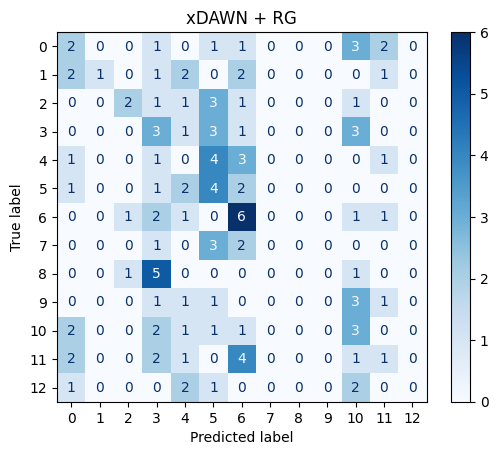

In [14]:
clf = make_pipeline(
    XdawnCovariances(nfilter=4, estimator = 'oas'),
    TangentSpace(),
    StandardScaler(),
    SVC(C = 3.3002033606845007, kernel = 'rbf', gamma = 'auto', class_weight = 'balanced', degree = 4)  # probability=True for predict_proba later
)
#pipeline.set_params(**study.best_params)
clf.fit(X_train, y_train)

preds_rg     = clf.predict(X_test)

# Printing the results
acc2         = np.mean(preds_rg == y_test)
print("Classification accuracy: %f " % (acc2))
plt.figure(1)
cm_rg = confusion_matrix(y_test, preds_rg)
disp_rg = ConfusionMatrixDisplay(confusion_matrix=cm_rg)
disp_rg.plot(cmap=plt.cm.Blues)
plt.title('xDAWN + RG')

plt.show()  # Display t

In [30]:
get_target_pairs()[12]

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]])

In [ ]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from sklearn.model_selection import cross_val_score
from functools import partial
import numpy as np
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils as np_utils, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import mne
from mne import io
from mne.datasets import sample
from Scripts.EEGModels import EEGNet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import warnings
import math
warnings.filterwarnings('ignore')

# 1. Define objective function
def objective(trial, X_train, y_train, pipeline):
    params = {
        # XdawnCovariances
        'xdawncovariances__nfilter': trial.suggest_int('nfilter', 2, 8),
        'xdawncovariances__estimator': trial.suggest_categorical('cov_est', ['scm', 'lwf', 'oas']),
        
        # TangentSpace
        'tangentspace__metric': trial.suggest_categorical('metric', ['riemann', 'logeuclid']),
        
        # LogisticRegression
        'logisticregression__C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'logisticregression__solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga']),
        'logisticregression__penalty': trial.suggest_categorical('penalty', ['l2', 'l1']),
        'logisticregression__class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }
    
    # Handle incompatible parameter combinations
    if params['logisticregression__penalty'] == 'l1':
        params['logisticregression__solver'] = 'liblinear'
    
    try:
        pipeline.set_params(**params)
        scores = cross_val_score(pipeline, X_train, y_train, 
                               cv=5, n_jobs=1, scoring='accuracy')
        print(scores)
        scores = [x for x in scores if x is not None and not (isinstance(x, float) and math.isnan(x))]
        print(scores)
        return np.mean(scores)
    except Exception as e:
        # Return negative infinity for failed trials
        print(f"Trial failed with params {params}: {str(e)}")
        return -np.inf

# 2. Configure and run study
def optimize_with_optuna(X_train, y_train, pipeline, n_trials=30):
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42),
        pruner=HyperbandPruner(min_resource=1, reduction_factor=3)
    )
    
    objective_func = partial(objective, X_train=X_train, y_train=y_train, pipeline=pipeline)
    study.optimize(objective_func, n_trials=n_trials, n_jobs=20)
    
    return study

n_components = 4  # pick some components
chans = 63
samples = 16001

# Data loading
subjects_cluster1 = [11, 4, 8, 15]
trial_cluster1 = [2, 2, 1, 2]
subjects_cluster2 = [15, 4, 3, 10, 1, 8, 6, 1, 6]
trial_cluster2 = [1, 1, 2, 2, 2, 2, 2, 1, 1]
subjects_cluster3 = [7, 7, 9, 9, 14]
trial_cluster3 = [2, 1, 2, 1, 1]
subjects_cluster4 = [5, 5, 3, 2, 2, 10, 12, 12, 16, 16, 11, 13, 13]
trial_cluster4 = [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1]

X, img, y = get_sample_choosen_trial(subjects_cluster4 + subjects_cluster3, trial_cluster4 + trial_cluster3)
X, img, y = get_sample()
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42
)

# 3. Usage with your EEG pipeline
pipeline = make_pipeline(
    XdawnCovariances(nfilter=4),
    TangentSpace(),
    LogisticRegression(max_iter=250)
)

study = optimize_with_optuna(X_train, Y_train, pipeline, n_trials=150)

# 4. Get best results
print(f"Best accuracy: {study.best_value:.3f}")
print("Best params:")
for k, v in study.best_params.items():
    print(f"{k:20s}: {v}")

# 5. Train final model with best params
pipeline.set_params(**study.best_params)
pipeline.fit(X_train, Y_train)

[I 2025-06-21 18:32:31,437] A new study created in memory with name: no-name-0bd95a25-56ec-48e5-ac37-8b67a70a670d
[I 2025-06-21 18:34:56,624] Trial 14 finished with value: 0.16094080338266387 and parameters: {'nfilter': 3, 'cov_est': 'oas', 'metric': 'riemann', 'C': 88.48816548357466, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.15909091        nan        nan 0.1627907 ]
[np.float64(0.1590909090909091), np.float64(0.16279069767441862)]


[I 2025-06-21 18:34:58,672] Trial 10 finished with value: 0.14931289640591966 and parameters: {'nfilter': 5, 'cov_est': 'scm', 'metric': 'riemann', 'C': 380.41213522736297, 'solver': 'saga', 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.15909091        nan        nan 0.13953488]
[np.float64(0.1590909090909091), np.float64(0.13953488372093023)]


[I 2025-06-21 18:35:04,377] Trial 4 finished with value: 0.14957716701902748 and parameters: {'nfilter': 5, 'cov_est': 'lwf', 'metric': 'riemann', 'C': 0.1300388505728845, 'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]


[I 2025-06-21 18:35:05,009] Trial 17 finished with value: 0.14957716701902748 and parameters: {'nfilter': 5, 'cov_est': 'oas', 'metric': 'logeuclid', 'C': 0.0028253582589121543, 'solver': 'lbfgs', 'penalty': 'l1', 'class_weight': None}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]


[I 2025-06-21 18:35:11,278] Trial 15 finished with value: 0.16094080338266387 and parameters: {'nfilter': 6, 'cov_est': 'lwf', 'metric': 'riemann', 'C': 0.003982444740701444, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.15909091        nan        nan 0.1627907 ]
[np.float64(0.1590909090909091), np.float64(0.16279069767441862)]


[I 2025-06-21 18:35:13,096] Trial 0 finished with value: 0.14957716701902748 and parameters: {'nfilter': 4, 'cov_est': 'scm', 'metric': 'logeuclid', 'C': 0.01554388698932314, 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]


[I 2025-06-21 18:35:22,620] Trial 9 finished with value: 0.14957716701902748 and parameters: {'nfilter': 8, 'cov_est': 'lwf', 'metric': 'riemann', 'C': 0.020801304045116036, 'solver': 'saga', 'penalty': 'l1', 'class_weight': None}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]


[I 2025-06-21 18:35:33,452] Trial 11 finished with value: 0.14931289640591966 and parameters: {'nfilter': 6, 'cov_est': 'oas', 'metric': 'logeuclid', 'C': 0.013787338801299872, 'solver': 'saga', 'penalty': 'l1', 'class_weight': None}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.15909091        nan        nan 0.13953488]
[np.float64(0.1590909090909091), np.float64(0.13953488372093023)]


[I 2025-06-21 18:36:04,134] Trial 16 finished with value: 0.14957716701902748 and parameters: {'nfilter': 5, 'cov_est': 'scm', 'metric': 'logeuclid', 'C': 0.0022191236828926235, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]


[I 2025-06-21 18:36:04,559] Trial 19 finished with value: 0.14957716701902748 and parameters: {'nfilter': 5, 'cov_est': 'lwf', 'metric': 'riemann', 'C': 0.0022936793811787737, 'solver': 'saga', 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]


[I 2025-06-21 18:36:05,293] Trial 8 finished with value: 0.16094080338266387 and parameters: {'nfilter': 8, 'cov_est': 'oas', 'metric': 'logeuclid', 'C': 0.26012243228172616, 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.16094080338266387.


[       nan 0.15909091        nan        nan 0.1627907 ]
[np.float64(0.1590909090909091), np.float64(0.16279069767441862)]


[I 2025-06-21 18:36:05,503] Trial 12 finished with value: 0.17230443974630022 and parameters: {'nfilter': 7, 'cov_est': 'scm', 'metric': 'logeuclid', 'C': 16.68011047827428, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None}. Best is trial 12 with value: 0.17230443974630022.


[       nan 0.18181818        nan        nan 0.1627907 ]
[np.float64(0.18181818181818182), np.float64(0.16279069767441862)]


[I 2025-06-21 18:36:05,933] Trial 2 finished with value: 0.14957716701902748 and parameters: {'nfilter': 3, 'cov_est': 'scm', 'metric': 'riemann', 'C': 0.0012992914063234668, 'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': None}. Best is trial 12 with value: 0.17230443974630022.
[I 2025-06-21 18:36:06,006] Trial 13 finished with value: 0.16094080338266387 and parameters: {'nfilter': 8, 'cov_est': 'scm', 'metric': 'logeuclid', 'C': 0.0010102297058103657, 'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': None}. Best is trial 12 with value: 0.17230443974630022.


[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]
[       nan 0.15909091        nan        nan 0.1627907 ]
[np.float64(0.1590909090909091), np.float64(0.16279069767441862)]


[I 2025-06-21 18:36:06,925] Trial 5 finished with value: 0.17230443974630022 and parameters: {'nfilter': 3, 'cov_est': 'scm', 'metric': 'logeuclid', 'C': 135.67537270500972, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.17230443974630022.
[I 2025-06-21 18:36:07,119] Trial 6 finished with value: 0.14931289640591966 and parameters: {'nfilter': 2, 'cov_est': 'lwf', 'metric': 'riemann', 'C': 0.13637203697305847, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None}. Best is trial 12 with value: 0.17230443974630022.


[       nan 0.18181818        nan        nan 0.1627907 ]
[np.float64(0.18181818181818182), np.float64(0.16279069767441862)]
[       nan 0.15909091        nan        nan 0.13953488]
[np.float64(0.1590909090909091), np.float64(0.13953488372093023)]


[I 2025-06-21 18:36:07,351] Trial 3 finished with value: 0.16094080338266387 and parameters: {'nfilter': 6, 'cov_est': 'lwf', 'metric': 'logeuclid', 'C': 0.5879606141335183, 'solver': 'lbfgs', 'penalty': 'l1', 'class_weight': None}. Best is trial 12 with value: 0.17230443974630022.


[       nan 0.15909091        nan        nan 0.1627907 ]
[np.float64(0.1590909090909091), np.float64(0.16279069767441862)]


[I 2025-06-21 18:36:07,957] Trial 1 finished with value: 0.16094080338266387 and parameters: {'nfilter': 6, 'cov_est': 'lwf', 'metric': 'riemann', 'C': 0.05949424431123253, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.17230443974630022.


[       nan 0.15909091        nan        nan 0.1627907 ]
[np.float64(0.1590909090909091), np.float64(0.16279069767441862)]


[I 2025-06-21 18:36:08,863] Trial 7 finished with value: 0.17230443974630022 and parameters: {'nfilter': 7, 'cov_est': 'oas', 'metric': 'logeuclid', 'C': 0.03228398292283431, 'solver': 'saga', 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.17230443974630022.
[I 2025-06-21 18:36:08,947] Trial 18 finished with value: 0.14957716701902748 and parameters: {'nfilter': 5, 'cov_est': 'oas', 'metric': 'riemann', 'C': 638.6757993085265, 'solver': 'lbfgs', 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.17230443974630022.


[       nan 0.18181818        nan        nan 0.1627907 ]
[np.float64(0.18181818181818182), np.float64(0.16279069767441862)]
[       nan 0.13636364        nan        nan 0.1627907 ]
[np.float64(0.13636363636363635), np.float64(0.16279069767441862)]


In [17]:
pipeline = make_pipeline(
    XdawnCovariances(nfilter=4, estimator='scm'),
    TangentSpace(metric='riemann'),
    LogisticRegression(max_iter=1000, C=0.004305877711891191, penalty='l2', class_weight='balanced', solver='lbfgs')
)


In [20]:
#X, img, y = get_sample_choosen_trial(subjects_cluster4 + subjects_cluster3, trial_cluster4 + trial_cluster3)
X, img, y = get_sample()
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=30
)
pipeline.fit(X_train, Y_train)
preds_rg     = pipeline.predict(X_test)

# Printing the results
acc2         = np.mean(preds_rg == Y_test)
print("Classification accuracy: %f " % (acc2))

plt.figure(1)
cm_rg = confusion_matrix(Y_test, preds_rg)
disp_rg = ConfusionMatrixDisplay(confusion_matrix=cm_rg)
disp_rg.plot(cmap=plt.cm.Blues)
plt.title('xDAWN + RG')

plt.show()  # Display t

LinAlgError: The leading minor of order 63 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

In [52]:
from collections import Counter
Counter(y)

Counter({np.int64(6): 29,
         np.int64(3): 27,
         np.int64(11): 26,
         np.int64(10): 26,
         np.int64(4): 26,
         np.int64(5): 25,
         np.int64(0): 24,
         np.int64(1): 23,
         np.int64(2): 22,
         np.int64(8): 18,
         np.int64(9): 17,
         np.int64(12): 16,
         np.int64(7): 15})

In [62]:
get_target_pairs()[5]

array([[0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0]])

In [27]:
X, img, y = get_sample_choosen_trial(subjects_cluster4, trial_cluster4)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42
)
Y_train[0]

np.int64(1)

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils as np_utils, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import mne
from mne import io
from mne.datasets import sample
from Scripts.EEGModels import EEGNet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

# Configure TensorFlow for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Set mixed precision policy for faster computation
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Data parameters
kernels, chans, samples = 1, 63, 16001

# Split data (keeping stratify for class balance)
X_train, X_temp, Y_train, y_temp = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Clean up memory
del X, y, X_temp, y_temp

# Convert data to GPU-friendly format
def prepare_data(X, Y):
    """Convert data to GPU-friendly format with proper reshaping and typing"""
    # Reshape with proper closing parenthesis
    X = np.reshape(X, (X.shape[0], chans, samples, kernels))
    
    # Convert labels to one-hot (using keras utils)
    Y = np_utils.to_categorical(Y)
    
    # Convert to TensorFlow tensors with optimal dtype
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    Y_tensor = tf.convert_to_tensor(Y, dtype=tf.float32)  # float32 for stability
    
    return X_tensor, Y_tensor

X_train, Y_train = prepare_data(X_train, Y_train)
X_val, Y_val = prepare_data(X_val, Y_val)
X_test, Y_test = prepare_data(X_test, Y_test)

# Create data pipelines for better GPU utilization
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)) \
    .shuffle(buffer_size=1024) \
    .batch(2, drop_remainder=True) \
    .prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)) \
    .batch(2) \
    .prefetch(tf.data.AUTOTUNE)

# Initialize model with CUDA-optimized settings
model = EEGNet(nb_classes=13, Chans=chans, Samples=samples,
               dropoutRate=0.5, kernLength=32, F1=8, D=2, F2=16,
               dropoutType='Dropout')

# Compile with CUDA-optimized Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'],
              run_eagerly=False)

# CUDA-optimized checkpointing
checkpoint = ModelCheckpoint('/tmp/checkpoint.h5',
                            monitor='val_accuracy',
                            save_best_only=True,
                            mode='max')

# Training with GPU acceleration
history = model.fit(train_dataset,
                    epochs=300,
                    validation_data=val_dataset,
                    callbacks=[checkpoint],
                    verbose=2)

# Load best weights
model.load_weights('/tmp/checkpoint.h5')

# GPU-accelerated prediction
test_probs = model.predict(X_test, batch_size=2)
test_preds = tf.argmax(test_probs, axis=-1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(test_preds, 
                         tf.argmax(Y_test, axis=-1)), tf.float32))
print(f"Classification accuracy: {accuracy.numpy():.4f}")

# PyRiemann portion (CPU-based)
X_train_cpu = X_train.numpy().reshape(-1, chans, samples)
X_test_cpu = X_test.numpy().reshape(-1, chans, samples)

clf = make_pipeline(XdawnCovariances(2),
                    TangentSpace(metric='riemann'),
                    LogisticRegression(max_iter=1000))
clf.fit(X_train_cpu, np.argmax(Y_train.numpy(), axis=-1))
rg_preds = clf.predict(X_test_cpu)
rg_acc = np.mean(rg_preds == np.argmax(Y_test.numpy(), axis=-1))
print(f"Riemannian Geometry accuracy: {rg_acc:.4f}")

# Plotting
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4',
               'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9',
               'Class 10', 'Class 11', 'Class 12']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ConfusionMatrixDisplay.from_predictions(
    np.argmax(Y_test.numpy(), axis=-1),
    test_preds.numpy(),
    display_labels=class_names,
    cmap='Blues',
    ax=ax1
)
ax1.set_title('EEGNet-8,2')

ConfusionMatrixDisplay.from_predictions(
    np.argmax(Y_test.numpy(), axis=-1),
    rg_preds,
    display_labels=class_names,
    cmap='Blues',
    ax=ax2
)
ax2.set_title('xDAWN + RG')

plt.tight_layout()
plt.show()

In [ ]:
probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

In [ ]:
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from Scripts.EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
#from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
kernels, chans, samples = 1, 63, 16001

# take 50/25/25 percent of the data to train/validate/test
X_train, X_temp, Y_train, y_temp = train_test_split(
    X, y,
    test_size=0.5,
    stratify=y,  # Сохраняем соотношение классов
    random_state=42  # Для воспроизводимости
)
X_validate, X_test, Y_validate, Y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

del X
del y
del X_temp
del y_temp

Y_train      = np_utils.to_categorical(Y_train)
Y_validate   = np_utils.to_categorical(Y_validate)
Y_test       = np_utils.to_categorical(Y_test)

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

n_components = 2  # pick some components

# set up sklearn pipeline
clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(metric='riemann'),
                    LogisticRegression())

preds_rg     = np.zeros(len(Y_test))

# reshape back to (trials, channels, samples)
X_train      = X_train.reshape(X_train.shape[0], chans, samples)
X_test       = X_test.reshape(X_test.shape[0], chans, samples)

# train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# labels need to be back in single-column format
clf.fit(X_train, Y_train.argmax(axis = -1))
preds_rg     = clf.predict(X_test)

# Printing the results
acc2         = np.mean(preds_rg == Y_test.argmax(axis = -1))
print("Classification accuracy: %f " % (acc2))

# plot the confusion matrices for both classifiers
names        = ['audio left', 'audio right', 'vis left', 'vis right']
'''plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'EEGNet-8,2')

plt.figure(1)
plot_confusion_matrix(preds_rg, Y_test.argmax(axis = -1), names, title = 'xDAWN + RG')'''


plt.figure(1)
cm_rg = confusion_matrix(Y_test.argmax(axis=-1), preds_rg)
disp_rg = ConfusionMatrixDisplay(confusion_matrix=cm_rg, display_labels=names)
disp_rg.plot(cmap=plt.cm.Blues)
plt.title('xDAWN + RG')

plt.show()  # Display the plots

In [ ]:
n_components = 4  # pick some components


get_sample_choosen_trial()

clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(metric='riemann'),
                    LogisticRegression())

preds_rg     = np.zeros(len(Y_test))

# reshape back to (trials, channels, samples)
X_train      = X_train.reshape(X_train.shape[0], chans, samples)
X_test       = X_test.reshape(X_test.shape[0], chans, samples)

# train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# labels need to be back in single-column format
clf.fit(X_train, Y_train.argmax(axis = -1))
preds_rg     = clf.predict(X_test)

# Printing the results
acc2         = np.mean(preds_rg == Y_test.argmax(axis = -1))
print("Classification accuracy: %f " % (acc2))

# plot the confusion matrices for both classifiers
names        = ['audio left', 'audio right', 'vis left', 'vis right']
'''plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'EEGNet-8,2')

plt.figure(1)
plot_confusion_matrix(preds_rg, Y_test.argmax(axis = -1), names, title = 'xDAWN + RG')'''


plt.figure(1)
cm_rg = confusion_matrix(Y_test.argmax(axis=-1), preds_rg)
disp_rg = ConfusionMatrixDisplay(confusion_matrix=cm_rg, display_labels=names)
disp_rg.plot(cmap=plt.cm.Blues)
plt.title('xDAWN + RG')

plt.show()  # Display the plots

In [ ]:
X_train.shape

In [ ]:
eeg[0]

In [ ]:
import numpy as np
np.stack(eeg).shape

In [ ]:
import collections
collections.Counter(labels)

In [ ]:
y

In [ ]:
label

In [ ]:
kernels, chans, samples = 1, 63, 16001